In [1]:
import numpy as np
import keras.utils
from keras.layers import Input,Dense, Flatten
from keras.models import load_model, Model
from keras.layers import Conv2D, UpSampling2D, AveragePooling2D, BatchNormalization
from keras.layers import LeakyReLU, Reshape
from keras.datasets import mnist
from keras.models import save_model
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
import time


sess = tf.Session()
K.set_session(sess)

Using TensorFlow backend.


### Three helper functions
1. generateTheta(L, dim) - generate L random samples from unit 'dim' space
2. generateQZ(batchsize, latent_dim) - generate samples from ideal q_z distribution
3. stitchImages(I, axis) - helps with visualization

In [2]:
def generateTheta(L, dim):
    res = [w / np.sqrt((w ** 2).sum()) for w in np.random.normal(size=(L, dim))]
    return np.asarray(res)

def generateQZ(batchsize, latent_dim):
    return np.random.normal(size=(batchsize, latent_dim))

def stitchImages(I, axis=0):
    n, N, M, K = I.shape
    if axis == 0:
        img = np.zeros((N * n, M, K))
        for i in range(n):
            img[i * N: (i + 1) * N, :, :] = I[i, :, :, :]
    else:
        img = np.zeros((N, M * n, K))
        for i in range(n):
            img[:, i * M: (i + 1) * M, :] = I[i, :, :, :]
    return img

## Autoencoder architecture

General layers/variables

In [3]:
img = Input((28, 28, 1))        # Input image - input layer for encoder 
interdim = 256                  # This is the dimension of intermediate latent variable (after convolution and before embedding)
latent_dim = 100                 # Dimension of the embedding space
code = Input((latent_dim,))     # Input code - input layer for decoder
depth = 64                      # "Depth" parameter for convolutional layers
L = 70                          # Number of random projections (thetas)
batchsize = 250                 # Size of one train batch
epochs_num = 600                # Number of epochs to train the autoencoder model

### ENCODER

In [4]:
with tf.variable_scope("swae_encoder"):
    x = Conv2D(depth * 1, kernel_size=(3, 3), padding="same")(img)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2D(depth * 1, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), padding="same")(x)
    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = AveragePooling2D(pool_size=(2, 2), padding="same")(x)
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = AveragePooling2D(pool_size=(2, 2), padding="same")(x)
    x = Flatten()(x)
    x = Dense(interdim, activation='relu')(x)
    encoded = Dense(latent_dim)(x)
swae_encoder = Model(img, encoded, name="SWAEEncoder")
swae_encoder.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "SWAEEncoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 28, 28, 64)        0         
_______________________________________

### DECODER

In [5]:
with tf.variable_scope("swae_decoder"):
    x = Dense(interdim)(code)
    x = Dense(depth * 64, activation='relu')(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Reshape((4, 4, depth * 4))(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="valid")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 4, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)

    x = Conv2D(depth * 2, kernel_size=(3, 3), padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)

    decoded = Conv2D(1, kernel_size=(3, 3), padding="same", activation='sigmoid')(x)
swae_decoder = Model(code, decoded, name="SWAEDecoder")
swae_decoder.summary()

Model: "SWAEDecoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               25856     
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              1052672   
_________________________________________________________________
batch_normalization_6 (Batch (None, 4096)              16384     
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 256)         

Define Keras variables for theta and q_z samples

In [6]:
theta_var = K.variable(generateTheta(L, latent_dim))
q_z_sample_var = K.variable(generateQZ(batchsize, latent_dim))

Define autoencoder model

In [7]:
img_encoded = swae_encoder(img)
z_decoded = swae_decoder(img_encoded)
swae_autoencoder = Model(img, z_decoded, name="SWAE")
swae_autoencoder.summary()

Model: "SWAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
SWAEEncoder (Model)          (None, 100)               2222116   
_________________________________________________________________
SWAEDecoder (Model)          (None, 28, 28, 1)         3901569   
Total params: 6,123,685
Trainable params: 6,112,549
Non-trainable params: 11,136
_________________________________________________________________


In [8]:
proj_encoded_samples = K.dot(img_encoded, K.transpose(theta_var))  # projection of the encoded samples
proj_q_z = K.dot(q_z_sample_var, K.transpose(theta_var))           # projection of ideal q_z samples

# Calculate Sliced Wasserstein distance by sorting the projections and calculating L2 distance
sliced_wass_dist = (tf.nn.top_k(tf.transpose(proj_encoded_samples), k=batchsize).values -
                    tf.nn.top_k(tf.transpose(proj_q_z), k=batchsize).values) ** 2

In [9]:
lambda_coeff = K.variable(10.0)

cross_entropy_loss = (1.0) * K.mean(K.binary_crossentropy(K.flatten(img), K.flatten(z_decoded)))
L1_loss = (1.0) * K.mean(K.abs(K.flatten(img) - K.flatten(z_decoded)))
sliced_wass_loss = lambda_coeff * K.mean(sliced_wass_dist)

swae_loss = L1_loss + cross_entropy_loss + sliced_wass_loss
# swae_loss = cross_entropy_loss + sliced_wass_loss
swae_autoencoder.add_loss(swae_loss)

In [10]:
swae_autoencoder.compile(optimizer='adam', loss='')

c:\Users\User\Desktop\Diploma\Autoencoder\venv\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output SWAEDecoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to SWAEDecoder.
  'be expecting any data to be passed to {0}.'.format(name))


### Load dataset

In [11]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train.astype('float32') / 255., 3)

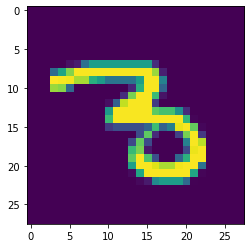

In [12]:
plt.imshow(np.squeeze(x_train[30, ...]))
plt.show()

### Train

In [13]:
digit_size = 28
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    plt.figure(figsize=(2 * n, 2 * len(args)))
    plt.imshow(figure, cmap='Greys_r')
    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch: [0/600], Batch: [239/240], Progress: 1.00%, Loss: 0.7716, Minimum loss per epoch: 0.6708
Epoch: [1/600], Batch: [239/240], Progress: 1.00%, Loss: 0.6721, Minimum loss per epoch: 0.5373
Epoch: [2/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5720, Minimum loss per epoch: 0.5153
Epoch: [3/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5653, Minimum loss per epoch: 0.4998
Epoch: [4/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5988, Minimum loss per epoch: 0.4597
Epoch: [5/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4632, Minimum loss per epoch: 0.4601
Epoch: [6/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4975, Minimum loss per epoch: 0.4439
Epoch: [7/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5835, Minimum loss per epoch: 0.4437
Epoch: [8/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5703, Minimum loss per epoch: 0.4348
Epoch: [9/600], Batch: [239/240], Progres

<Figure size 432x288 with 0 Axes>

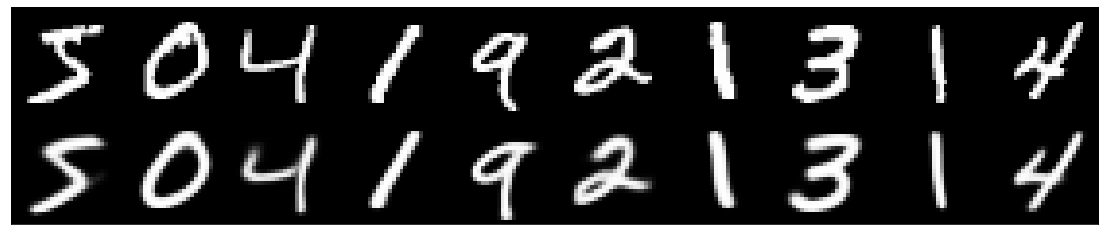

Epoch: [10/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4919, Minimum loss per epoch: 0.4142
Epoch: [11/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4566, Minimum loss per epoch: 0.4179
Epoch: [12/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5431, Minimum loss per epoch: 0.4031
Epoch: [13/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5258, Minimum loss per epoch: 0.4093
Epoch: [14/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5240, Minimum loss per epoch: 0.4158
Epoch: [15/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4371, Minimum loss per epoch: 0.4023
Epoch: [16/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5868, Minimum loss per epoch: 0.3897
Epoch: [17/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4233, Minimum loss per epoch: 0.3943
Epoch: [18/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4904, Minimum loss per epoch: 0.3955
Epoch: [19/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4982, Minimum loss per epoch: 0.4040


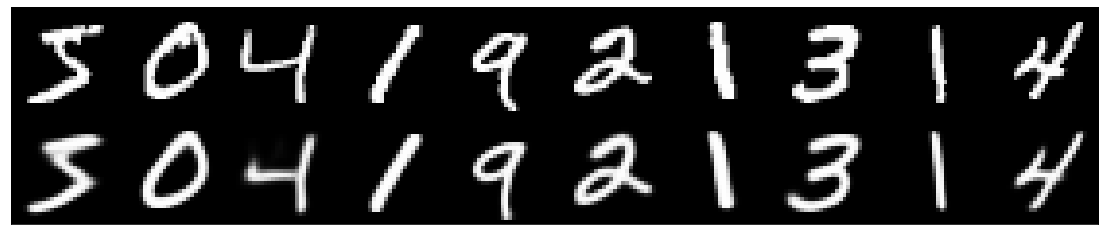

Epoch: [20/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4589, Minimum loss per epoch: 0.3901
Epoch: [21/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4614, Minimum loss per epoch: 0.3822
Epoch: [22/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4866, Minimum loss per epoch: 0.3868
Epoch: [23/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4928, Minimum loss per epoch: 0.3878
Epoch: [24/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4536, Minimum loss per epoch: 0.3923
Epoch: [25/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4061, Minimum loss per epoch: 0.3777
Epoch: [26/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3970, Minimum loss per epoch: 0.3644
Epoch: [27/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4312, Minimum loss per epoch: 0.3645
Epoch: [28/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4220, Minimum loss per epoch: 0.3850
Epoch: [29/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4689, Minimum loss per epoch: 0.3770


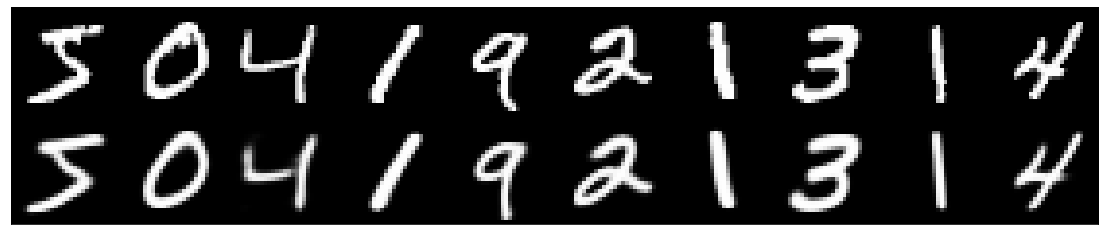

Epoch: [30/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4572, Minimum loss per epoch: 0.3745
Epoch: [31/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4221, Minimum loss per epoch: 0.3676
Epoch: [32/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5397, Minimum loss per epoch: 0.3522
Epoch: [33/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4013, Minimum loss per epoch: 0.3707
Epoch: [34/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4389, Minimum loss per epoch: 0.3546
Epoch: [35/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4636, Minimum loss per epoch: 0.3573
Epoch: [36/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4315, Minimum loss per epoch: 0.3608
Epoch: [37/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4359, Minimum loss per epoch: 0.3596
Epoch: [38/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4593, Minimum loss per epoch: 0.3569
Epoch: [39/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4458, Minimum loss per epoch: 0.3566


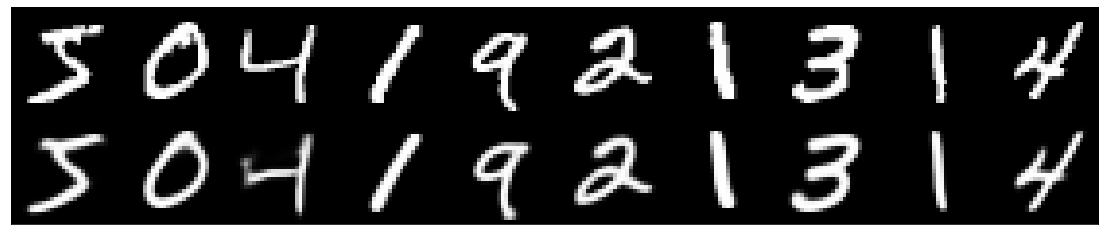

Epoch: [40/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4363, Minimum loss per epoch: 0.3538
Epoch: [41/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4356, Minimum loss per epoch: 0.3589
Epoch: [42/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4951, Minimum loss per epoch: 0.3510
Epoch: [43/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4603, Minimum loss per epoch: 0.3555
Epoch: [44/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4004, Minimum loss per epoch: 0.3504
Epoch: [45/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4159, Minimum loss per epoch: 0.3490
Epoch: [46/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3973, Minimum loss per epoch: 0.3486
Epoch: [47/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4581, Minimum loss per epoch: 0.3567
Epoch: [48/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4554, Minimum loss per epoch: 0.3478
Epoch: [49/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4438, Minimum loss per epoch: 0.3471


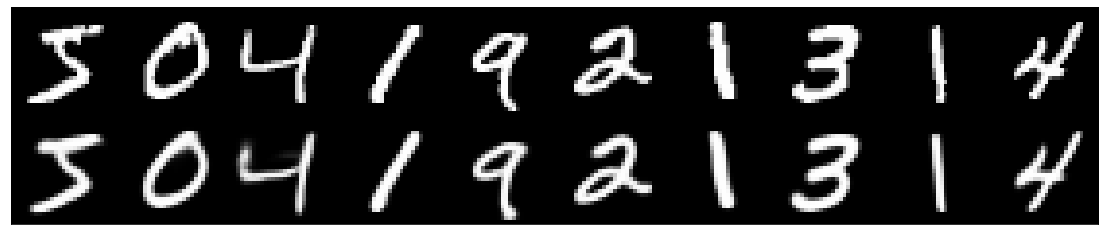

Epoch: [50/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4152, Minimum loss per epoch: 0.3418
Epoch: [51/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3771, Minimum loss per epoch: 0.3428
Epoch: [52/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4244, Minimum loss per epoch: 0.3381
Epoch: [53/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4048, Minimum loss per epoch: 0.3393
Epoch: [54/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4286, Minimum loss per epoch: 0.3329
Epoch: [55/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4214, Minimum loss per epoch: 0.3257
Epoch: [56/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4068, Minimum loss per epoch: 0.3434
Epoch: [57/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4006, Minimum loss per epoch: 0.3425
Epoch: [58/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3634, Minimum loss per epoch: 0.3366
Epoch: [59/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3936, Minimum loss per epoch: 0.3308


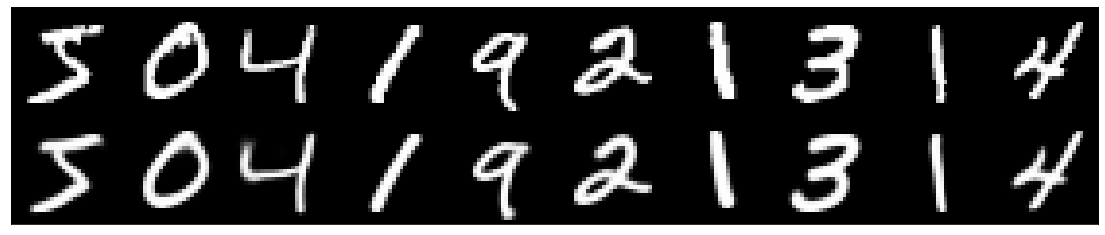

Epoch: [60/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3933, Minimum loss per epoch: 0.3288
Epoch: [61/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3892, Minimum loss per epoch: 0.3241
Epoch: [62/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3921, Minimum loss per epoch: 0.3225
Epoch: [63/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4061, Minimum loss per epoch: 0.3313
Epoch: [64/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4123, Minimum loss per epoch: 0.3159
Epoch: [65/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3621, Minimum loss per epoch: 0.3398
Epoch: [66/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4160, Minimum loss per epoch: 0.3295
Epoch: [67/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4072, Minimum loss per epoch: 0.3339
Epoch: [68/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3845, Minimum loss per epoch: 0.3311
Epoch: [69/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3860, Minimum loss per epoch: 0.3407


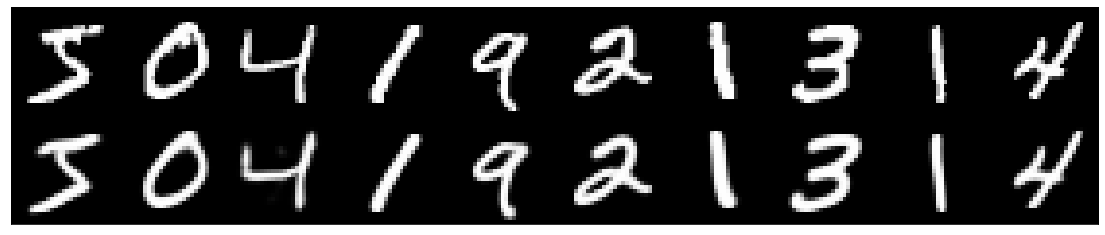

Epoch: [70/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4291, Minimum loss per epoch: 0.3046
Epoch: [71/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3239, Minimum loss per epoch: 0.3239
Epoch: [72/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3968, Minimum loss per epoch: 0.3205
Epoch: [73/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3880, Minimum loss per epoch: 0.3236
Epoch: [74/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3659, Minimum loss per epoch: 0.3322
Epoch: [75/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3893, Minimum loss per epoch: 0.3199
Epoch: [76/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3920, Minimum loss per epoch: 0.3189
Epoch: [77/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3902, Minimum loss per epoch: 0.3345
Epoch: [78/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3648, Minimum loss per epoch: 0.3169
Epoch: [79/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3801, Minimum loss per epoch: 0.3141


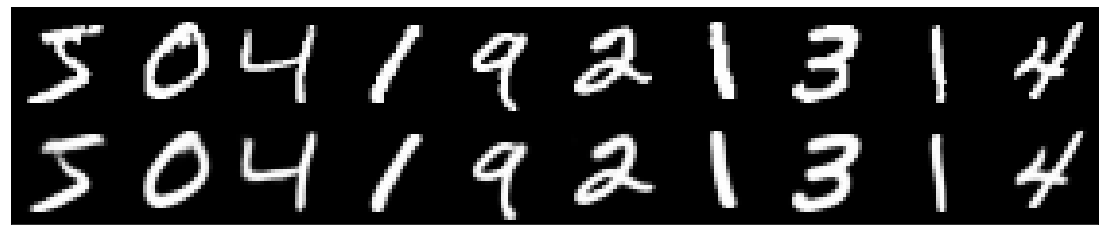

Epoch: [80/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3841, Minimum loss per epoch: 0.3187
Epoch: [81/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3629, Minimum loss per epoch: 0.3279
Epoch: [82/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3408, Minimum loss per epoch: 0.3174
Epoch: [83/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4497, Minimum loss per epoch: 0.3228
Epoch: [84/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3814, Minimum loss per epoch: 0.3220
Epoch: [85/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3723, Minimum loss per epoch: 0.3240
Epoch: [86/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3685, Minimum loss per epoch: 0.3243
Epoch: [87/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4137, Minimum loss per epoch: 0.3193
Epoch: [88/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3309, Minimum loss per epoch: 0.3192
Epoch: [89/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3780, Minimum loss per epoch: 0.3172


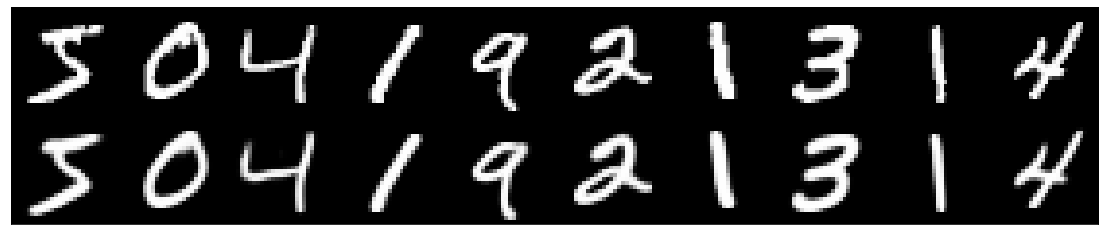

Epoch: [90/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4290, Minimum loss per epoch: 0.3218
Epoch: [91/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3235, Minimum loss per epoch: 0.3235
Epoch: [92/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3562, Minimum loss per epoch: 0.3138
Epoch: [93/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3996, Minimum loss per epoch: 0.3079
Epoch: [94/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3982, Minimum loss per epoch: 0.3028
Epoch: [95/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3677, Minimum loss per epoch: 0.3219
Epoch: [96/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4168, Minimum loss per epoch: 0.3167
Epoch: [97/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3918, Minimum loss per epoch: 0.3136
Epoch: [98/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4104, Minimum loss per epoch: 0.3193
Epoch: [99/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3190, Minimum loss per epoch: 0.3135


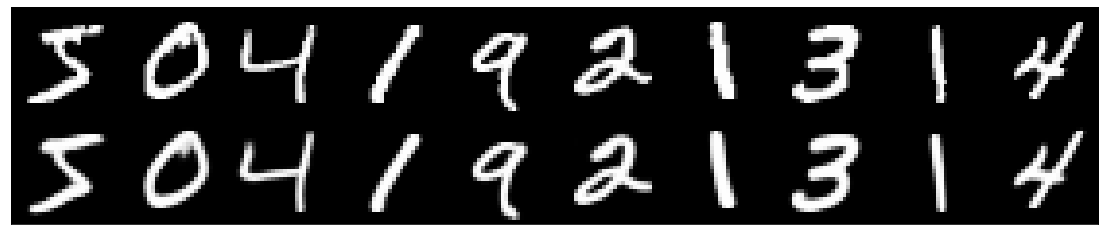

Epoch: [100/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3713, Minimum loss per epoch: 0.2970
Epoch: [101/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3644, Minimum loss per epoch: 0.3232
Epoch: [102/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3937, Minimum loss per epoch: 0.2976
Epoch: [103/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3616, Minimum loss per epoch: 0.3195
Epoch: [104/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4152, Minimum loss per epoch: 0.3086
Epoch: [105/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4195, Minimum loss per epoch: 0.3169
Epoch: [106/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3670, Minimum loss per epoch: 0.3193
Epoch: [107/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3540, Minimum loss per epoch: 0.3199
Epoch: [108/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3644, Minimum loss per epoch: 0.3142
Epoch: [109/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3802, Minimum loss per epoch: 0.3110


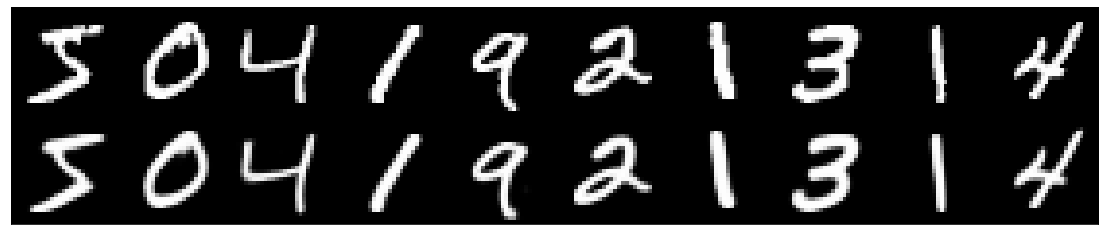

Epoch: [110/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3544, Minimum loss per epoch: 0.3199
Epoch: [111/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4086, Minimum loss per epoch: 0.3150
Epoch: [112/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3636, Minimum loss per epoch: 0.3170
Epoch: [113/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3624, Minimum loss per epoch: 0.3131
Epoch: [114/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3639, Minimum loss per epoch: 0.3066
Epoch: [115/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4039, Minimum loss per epoch: 0.3099
Epoch: [116/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3815, Minimum loss per epoch: 0.3141
Epoch: [117/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3357, Minimum loss per epoch: 0.3136
Epoch: [118/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3884, Minimum loss per epoch: 0.3184
Epoch: [119/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3781, Minimum loss per epoch: 0.2993


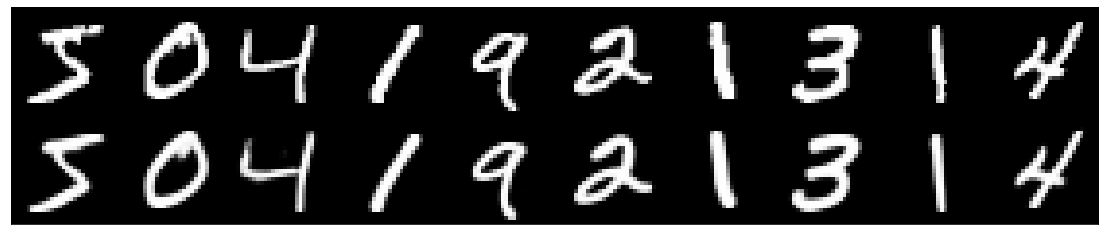

Epoch: [120/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3690, Minimum loss per epoch: 0.3077
Epoch: [121/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3977, Minimum loss per epoch: 0.3171
Epoch: [122/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3542, Minimum loss per epoch: 0.3072
Epoch: [123/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3074, Minimum loss per epoch: 0.3074
Epoch: [124/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3537, Minimum loss per epoch: 0.2987
Epoch: [125/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3744, Minimum loss per epoch: 0.3026
Epoch: [126/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3978, Minimum loss per epoch: 0.2955
Epoch: [127/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3624, Minimum loss per epoch: 0.2988
Epoch: [128/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3758, Minimum loss per epoch: 0.3093
Epoch: [129/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3979, Minimum loss per epoch: 0.3089


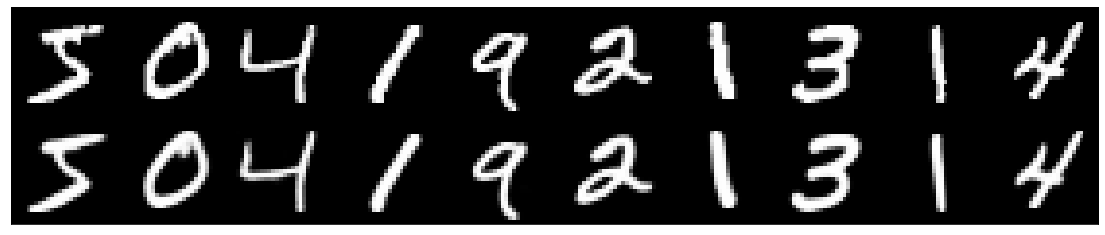

Epoch: [130/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3706, Minimum loss per epoch: 0.2967
Epoch: [131/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3698, Minimum loss per epoch: 0.3093
Epoch: [132/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3868, Minimum loss per epoch: 0.3102
Epoch: [133/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3781, Minimum loss per epoch: 0.2986
Epoch: [134/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3354, Minimum loss per epoch: 0.3041
Epoch: [135/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3941, Minimum loss per epoch: 0.3011
Epoch: [136/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3321, Minimum loss per epoch: 0.2919
Epoch: [137/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3829, Minimum loss per epoch: 0.3082
Epoch: [138/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3457, Minimum loss per epoch: 0.3029
Epoch: [139/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3524, Minimum loss per epoch: 0.3090


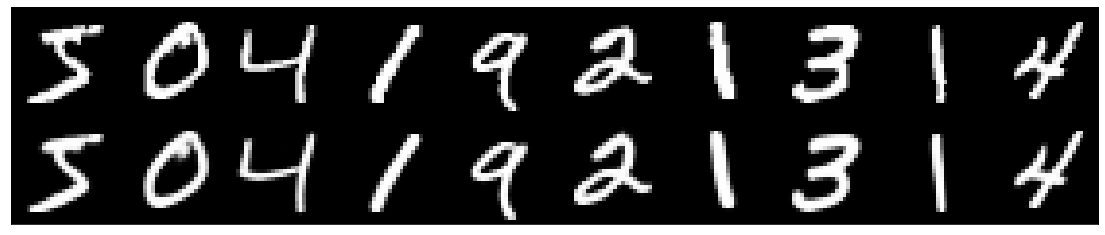

Epoch: [140/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3397, Minimum loss per epoch: 0.3127
Epoch: [141/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3467, Minimum loss per epoch: 0.3065
Epoch: [142/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4040, Minimum loss per epoch: 0.2918
Epoch: [143/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3332, Minimum loss per epoch: 0.3117
Epoch: [144/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3939, Minimum loss per epoch: 0.2882
Epoch: [145/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3786, Minimum loss per epoch: 0.3101
Epoch: [146/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3320, Minimum loss per epoch: 0.2943
Epoch: [147/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3963, Minimum loss per epoch: 0.3009
Epoch: [148/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3879, Minimum loss per epoch: 0.3027
Epoch: [149/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3560, Minimum loss per epoch: 0.3073


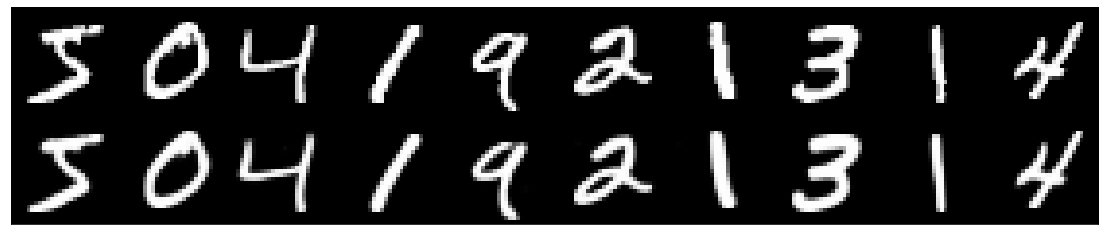

Epoch: [150/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4037, Minimum loss per epoch: 0.3004
Epoch: [151/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3848, Minimum loss per epoch: 0.3056
Epoch: [152/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3653, Minimum loss per epoch: 0.3076
Epoch: [153/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3500, Minimum loss per epoch: 0.2911
Epoch: [154/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3361, Minimum loss per epoch: 0.2960
Epoch: [155/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3833, Minimum loss per epoch: 0.2961
Epoch: [156/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3566, Minimum loss per epoch: 0.3036
Epoch: [157/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4010, Minimum loss per epoch: 0.3065
Epoch: [158/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3063, Minimum loss per epoch: 0.2965
Epoch: [159/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3261, Minimum loss per epoch: 0.3027


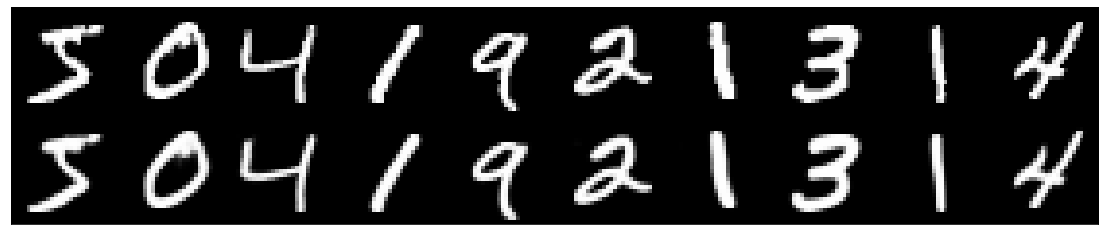

Epoch: [160/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3756, Minimum loss per epoch: 0.2867
Epoch: [161/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3653, Minimum loss per epoch: 0.2874
Epoch: [162/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3213, Minimum loss per epoch: 0.3006
Epoch: [163/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3604, Minimum loss per epoch: 0.3045
Epoch: [164/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3952, Minimum loss per epoch: 0.2892
Epoch: [165/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3442, Minimum loss per epoch: 0.3015
Epoch: [166/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3814, Minimum loss per epoch: 0.3037
Epoch: [167/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3199, Minimum loss per epoch: 0.3073
Epoch: [168/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3459, Minimum loss per epoch: 0.3041
Epoch: [169/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3850, Minimum loss per epoch: 0.2944


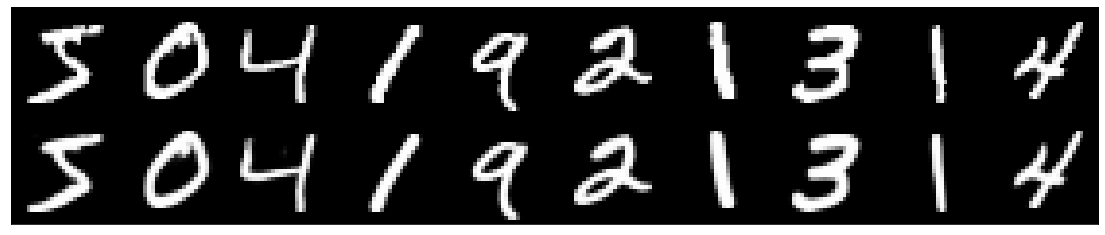

Epoch: [170/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3742, Minimum loss per epoch: 0.3049
Epoch: [171/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3877, Minimum loss per epoch: 0.2937
Epoch: [172/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3138, Minimum loss per epoch: 0.2954
Epoch: [173/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3508, Minimum loss per epoch: 0.2920
Epoch: [174/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3113, Minimum loss per epoch: 0.2961
Epoch: [175/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3792, Minimum loss per epoch: 0.2947
Epoch: [176/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3651, Minimum loss per epoch: 0.2999
Epoch: [177/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3562, Minimum loss per epoch: 0.3039
Epoch: [178/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3514, Minimum loss per epoch: 0.3002
Epoch: [179/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3396, Minimum loss per epoch: 0.3085


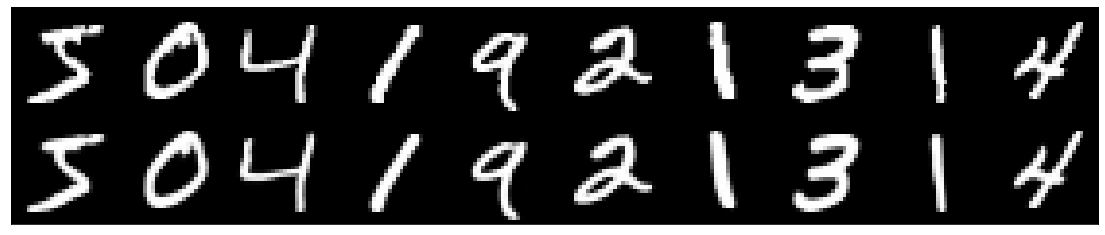

Epoch: [180/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3433, Minimum loss per epoch: 0.3013
Epoch: [181/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3409, Minimum loss per epoch: 0.3041
Epoch: [182/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3360, Minimum loss per epoch: 0.2983
Epoch: [183/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3388, Minimum loss per epoch: 0.3070
Epoch: [184/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3899, Minimum loss per epoch: 0.2969
Epoch: [185/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3167, Minimum loss per epoch: 0.2941
Epoch: [186/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4077, Minimum loss per epoch: 0.2938
Epoch: [187/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3409, Minimum loss per epoch: 0.3005
Epoch: [188/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3213, Minimum loss per epoch: 0.3051
Epoch: [189/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3438, Minimum loss per epoch: 0.3046


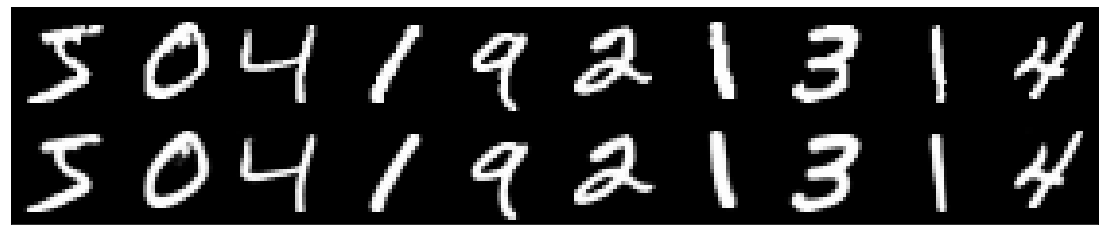

Epoch: [190/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3370, Minimum loss per epoch: 0.2913
Epoch: [191/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3887, Minimum loss per epoch: 0.3031
Epoch: [192/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3459, Minimum loss per epoch: 0.2994
Epoch: [193/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3572, Minimum loss per epoch: 0.2860
Epoch: [194/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3832, Minimum loss per epoch: 0.2990
Epoch: [195/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3713, Minimum loss per epoch: 0.3016
Epoch: [196/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3411, Minimum loss per epoch: 0.2904
Epoch: [197/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3491, Minimum loss per epoch: 0.2992
Epoch: [198/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3419, Minimum loss per epoch: 0.2978
Epoch: [199/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3722, Minimum loss per epoch: 0.3073


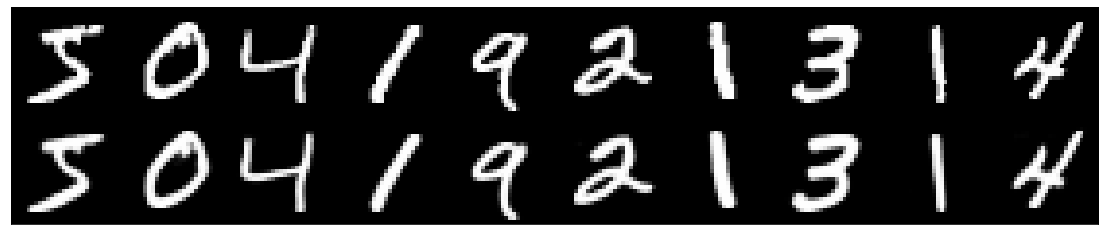

Epoch: [200/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3415, Minimum loss per epoch: 0.2704
Epoch: [201/600], Batch: [239/240], Progress: 1.00%, Loss: 0.3885, Minimum loss per epoch: 0.3076
Epoch: [202/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4733, Minimum loss per epoch: 0.3479
Epoch: [203/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4048, Minimum loss per epoch: 0.3669
Epoch: [204/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4447, Minimum loss per epoch: 0.4004
Epoch: [205/600], Batch: [239/240], Progress: 1.00%, Loss: 0.4644, Minimum loss per epoch: 0.4269
Epoch: [206/600], Batch: [239/240], Progress: 1.00%, Loss: 0.6112, Minimum loss per epoch: 0.4557
Epoch: [207/600], Batch: [239/240], Progress: 1.00%, Loss: 0.5924, Minimum loss per epoch: 0.5182
Epoch: [208/600], Batch: [239/240], Progress: 1.00%, Loss: 0.6292, Minimum loss per epoch: 0.5505
Epoch: [209/600], Batch: [239/240], Progress: 1.00%, Loss: 0.7139, Minimum loss per epoch: 0.5976


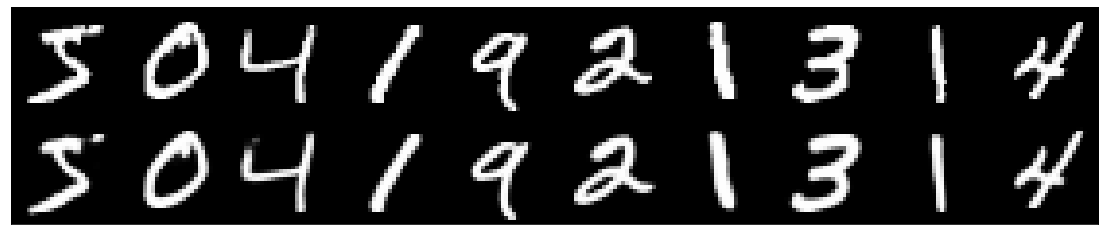

Epoch: [210/600], Batch: [239/240], Progress: 1.00%, Loss: 0.7784, Minimum loss per epoch: 0.6417
Epoch: [211/600], Batch: [239/240], Progress: 1.00%, Loss: 0.8242, Minimum loss per epoch: 0.6853
Epoch: [212/600], Batch: [239/240], Progress: 1.00%, Loss: 1.0143, Minimum loss per epoch: 0.7866
Epoch: [213/600], Batch: [239/240], Progress: 1.00%, Loss: 1.0627, Minimum loss per epoch: 0.8354
Epoch: [214/600], Batch: [239/240], Progress: 1.00%, Loss: 1.1603, Minimum loss per epoch: 0.8339
Epoch: [215/600], Batch: [239/240], Progress: 1.00%, Loss: 1.2227, Minimum loss per epoch: 0.9954
Epoch: [216/600], Batch: [239/240], Progress: 1.00%, Loss: 1.3411, Minimum loss per epoch: 1.0610
Epoch: [217/600], Batch: [239/240], Progress: 1.00%, Loss: 1.3965, Minimum loss per epoch: 1.1859
Epoch: [218/600], Batch: [239/240], Progress: 1.00%, Loss: 1.7536, Minimum loss per epoch: 1.2566
Epoch: [219/600], Batch: [239/240], Progress: 1.00%, Loss: 1.6094, Minimum loss per epoch: 1.4236


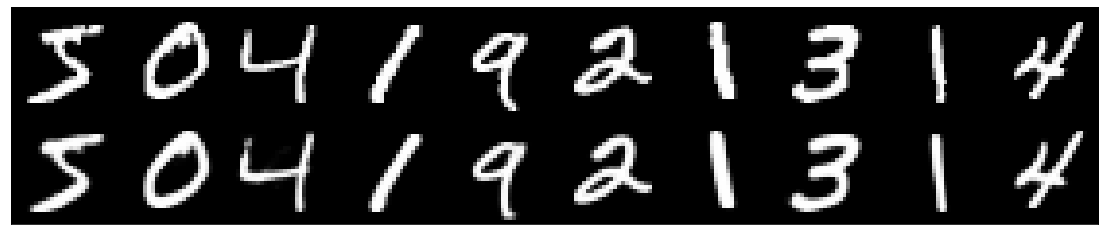

Epoch: [220/600], Batch: [239/240], Progress: 1.00%, Loss: 1.8923, Minimum loss per epoch: 1.4996
Epoch: [221/600], Batch: [239/240], Progress: 1.00%, Loss: 2.3115, Minimum loss per epoch: 1.6729
Epoch: [222/600], Batch: [239/240], Progress: 1.00%, Loss: 2.5168, Minimum loss per epoch: 1.8559
Epoch: [223/600], Batch: [239/240], Progress: 1.00%, Loss: 2.2454, Minimum loss per epoch: 2.0103
Epoch: [224/600], Batch: [239/240], Progress: 1.00%, Loss: 2.6977, Minimum loss per epoch: 2.2405
Epoch: [225/600], Batch: [239/240], Progress: 1.00%, Loss: 2.7188, Minimum loss per epoch: 2.3527
Epoch: [226/600], Batch: [239/240], Progress: 1.00%, Loss: 3.5419, Minimum loss per epoch: 2.6490
Epoch: [227/600], Batch: [239/240], Progress: 1.00%, Loss: 3.1877, Minimum loss per epoch: 2.8565
Epoch: [228/600], Batch: [239/240], Progress: 1.00%, Loss: 4.2995, Minimum loss per epoch: 3.2261
Epoch: [229/600], Batch: [239/240], Progress: 1.00%, Loss: 3.6537, Minimum loss per epoch: 3.5367


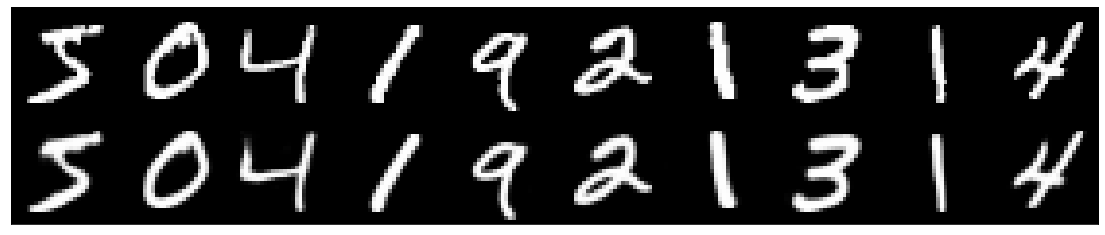

Epoch: [230/600], Batch: [239/240], Progress: 1.00%, Loss: 4.5087, Minimum loss per epoch: 3.7251
Epoch: [231/600], Batch: [239/240], Progress: 1.00%, Loss: 5.5707, Minimum loss per epoch: 4.1136
Epoch: [232/600], Batch: [239/240], Progress: 1.00%, Loss: 5.2153, Minimum loss per epoch: 4.7214
Epoch: [233/600], Batch: [239/240], Progress: 1.00%, Loss: 6.5743, Minimum loss per epoch: 4.8511
Epoch: [234/600], Batch: [239/240], Progress: 1.00%, Loss: 7.0060, Minimum loss per epoch: 5.7581
Epoch: [235/600], Batch: [239/240], Progress: 1.00%, Loss: 9.3619, Minimum loss per epoch: 6.1235
Epoch: [236/600], Batch: [239/240], Progress: 1.00%, Loss: 7.6054, Minimum loss per epoch: 6.7567
Epoch: [237/600], Batch: [239/240], Progress: 1.00%, Loss: 9.7973, Minimum loss per epoch: 7.1747
Epoch: [238/600], Batch: [239/240], Progress: 1.00%, Loss: 11.8197, Minimum loss per epoch: 8.0890
Epoch: [239/600], Batch: [239/240], Progress: 1.00%, Loss: 14.0728, Minimum loss per epoch: 8.7612


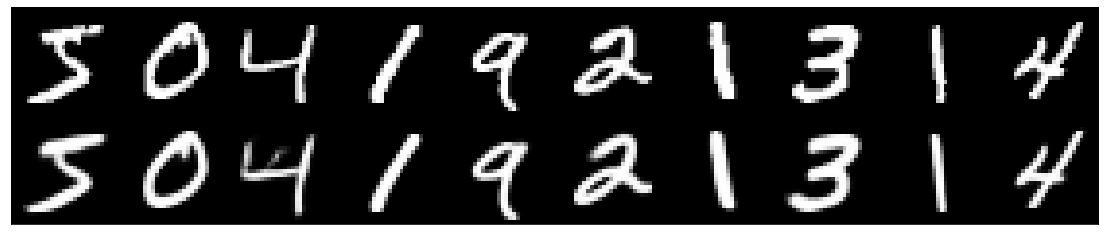

Epoch: [240/600], Batch: [239/240], Progress: 1.00%, Loss: 10.5709, Minimum loss per epoch: 9.5913
Epoch: [241/600], Batch: [239/240], Progress: 1.00%, Loss: 13.7471, Minimum loss per epoch: 10.6676
Epoch: [242/600], Batch: [239/240], Progress: 1.00%, Loss: 17.1627, Minimum loss per epoch: 11.8103
Epoch: [243/600], Batch: [239/240], Progress: 1.00%, Loss: 19.0845, Minimum loss per epoch: 12.4621
Epoch: [244/600], Batch: [239/240], Progress: 1.00%, Loss: 19.3964, Minimum loss per epoch: 14.3999
Epoch: [245/600], Batch: [239/240], Progress: 1.00%, Loss: 17.8490, Minimum loss per epoch: 15.4116
Epoch: [246/600], Batch: [239/240], Progress: 1.00%, Loss: 25.1797, Minimum loss per epoch: 17.1737
Epoch: [247/600], Batch: [239/240], Progress: 1.00%, Loss: 27.3458, Minimum loss per epoch: 18.2737
Epoch: [248/600], Batch: [239/240], Progress: 1.00%, Loss: 26.0927, Minimum loss per epoch: 21.6312
Epoch: [249/600], Batch: [239/240], Progress: 1.00%, Loss: 29.0875, Minimum loss per epoch: 21.8850


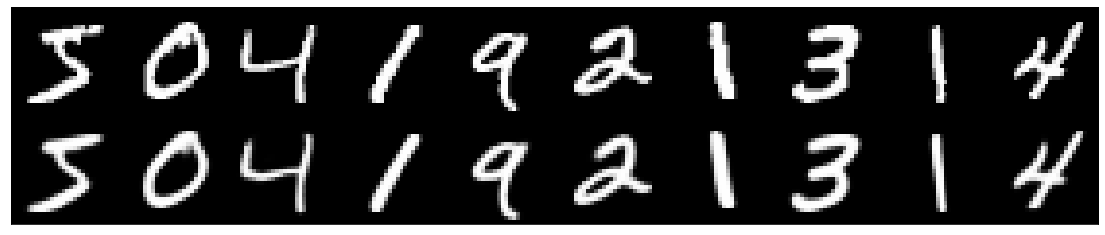

Epoch: [250/600], Batch: [239/240], Progress: 1.00%, Loss: 31.5394, Minimum loss per epoch: 24.5747
Epoch: [251/600], Batch: [239/240], Progress: 1.00%, Loss: 34.5590, Minimum loss per epoch: 25.3045
Epoch: [252/600], Batch: [239/240], Progress: 1.00%, Loss: 38.1721, Minimum loss per epoch: 28.4142
Epoch: [253/600], Batch: [239/240], Progress: 1.00%, Loss: 39.3958, Minimum loss per epoch: 33.3145
Epoch: [254/600], Batch: [239/240], Progress: 1.00%, Loss: 43.6636, Minimum loss per epoch: 36.8931
Epoch: [255/600], Batch: [239/240], Progress: 1.00%, Loss: 56.6952, Minimum loss per epoch: 38.6569
Epoch: [256/600], Batch: [239/240], Progress: 1.00%, Loss: 57.8197, Minimum loss per epoch: 43.2856
Epoch: [257/600], Batch: [239/240], Progress: 1.00%, Loss: 60.2511, Minimum loss per epoch: 49.9522
Epoch: [258/600], Batch: [239/240], Progress: 1.00%, Loss: 70.1773, Minimum loss per epoch: 53.3326
Epoch: [259/600], Batch: [239/240], Progress: 1.00%, Loss: 75.5805, Minimum loss per epoch: 61.8751


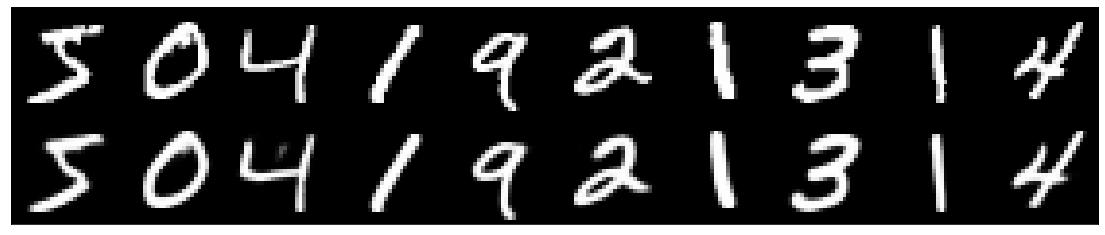

Epoch: [260/600], Batch: [239/240], Progress: 1.00%, Loss: 80.7764, Minimum loss per epoch: 66.0883
Epoch: [261/600], Batch: [239/240], Progress: 1.00%, Loss: 96.3586, Minimum loss per epoch: 73.8540
Epoch: [262/600], Batch: [239/240], Progress: 1.00%, Loss: 100.3137, Minimum loss per epoch: 79.7024
Epoch: [263/600], Batch: [239/240], Progress: 1.00%, Loss: 123.2292, Minimum loss per epoch: 84.7901
Epoch: [264/600], Batch: [239/240], Progress: 1.00%, Loss: 118.0035, Minimum loss per epoch: 97.6114
Epoch: [265/600], Batch: [239/240], Progress: 1.00%, Loss: 166.2630, Minimum loss per epoch: 102.5450
Epoch: [266/600], Batch: [239/240], Progress: 1.00%, Loss: 160.3479, Minimum loss per epoch: 122.5880
Epoch: [267/600], Batch: [239/240], Progress: 1.00%, Loss: 172.1731, Minimum loss per epoch: 120.2947
Epoch: [268/600], Batch: [239/240], Progress: 1.00%, Loss: 182.9667, Minimum loss per epoch: 133.1875
Epoch: [269/600], Batch: [239/240], Progress: 1.00%, Loss: 226.4586, Minimum loss per epo

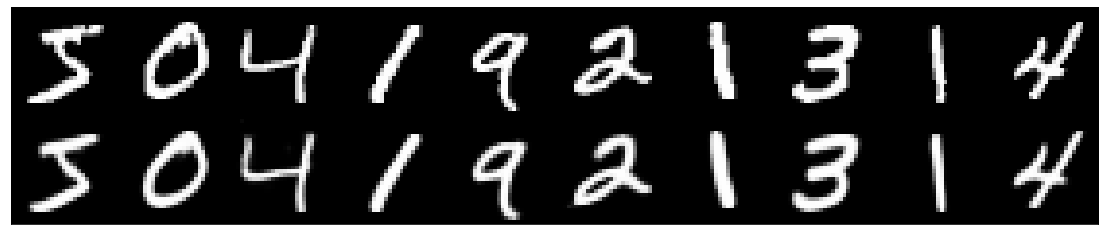

Epoch: [270/600], Batch: [239/240], Progress: 1.00%, Loss: 221.4633, Minimum loss per epoch: 169.3521
Epoch: [271/600], Batch: [239/240], Progress: 1.00%, Loss: 235.6494, Minimum loss per epoch: 185.0230
Epoch: [272/600], Batch: [239/240], Progress: 1.00%, Loss: 240.2179, Minimum loss per epoch: 205.7893
Epoch: [273/600], Batch: [239/240], Progress: 1.00%, Loss: 268.6211, Minimum loss per epoch: 205.4563
Epoch: [274/600], Batch: [239/240], Progress: 1.00%, Loss: 280.3844, Minimum loss per epoch: 242.3320
Epoch: [275/600], Batch: [239/240], Progress: 1.00%, Loss: 314.5416, Minimum loss per epoch: 244.4151
Epoch: [276/600], Batch: [239/240], Progress: 1.00%, Loss: 363.4176, Minimum loss per epoch: 297.3654
Epoch: [277/600], Batch: [239/240], Progress: 1.00%, Loss: 399.2247, Minimum loss per epoch: 331.5172
Epoch: [278/600], Batch: [239/240], Progress: 1.00%, Loss: 423.6874, Minimum loss per epoch: 351.8641
Epoch: [279/600], Batch: [239/240], Progress: 1.00%, Loss: 463.8030, Minimum loss 

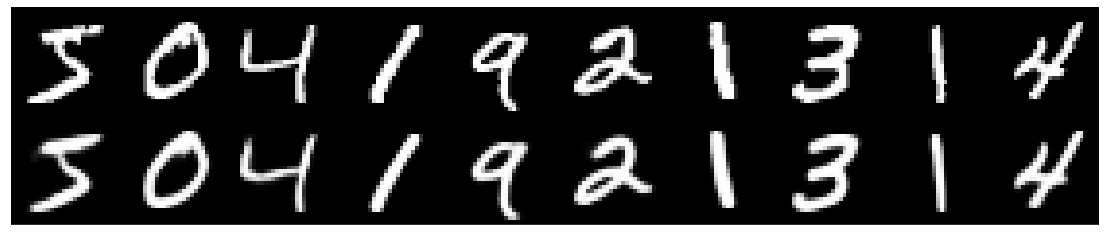

Epoch: [280/600], Batch: [239/240], Progress: 1.00%, Loss: 464.7219, Minimum loss per epoch: 441.3004
Epoch: [281/600], Batch: [239/240], Progress: 1.00%, Loss: 688.8265, Minimum loss per epoch: 463.9763
Epoch: [282/600], Batch: [239/240], Progress: 1.00%, Loss: 675.2507, Minimum loss per epoch: 522.9821
Epoch: [283/600], Batch: [239/240], Progress: 1.00%, Loss: 804.7311, Minimum loss per epoch: 538.9325
Epoch: [284/600], Batch: [239/240], Progress: 1.00%, Loss: 800.7669, Minimum loss per epoch: 639.9772
Epoch: [285/600], Batch: [239/240], Progress: 1.00%, Loss: 921.9233, Minimum loss per epoch: 703.3524
Epoch: [286/600], Batch: [239/240], Progress: 1.00%, Loss: 1038.7000, Minimum loss per epoch: 699.8202
Epoch: [287/600], Batch: [239/240], Progress: 1.00%, Loss: 938.0509, Minimum loss per epoch: 830.5217
Epoch: [288/600], Batch: [239/240], Progress: 1.00%, Loss: 1115.6342, Minimum loss per epoch: 906.4754
Epoch: [289/600], Batch: [239/240], Progress: 1.00%, Loss: 1220.8844, Minimum lo

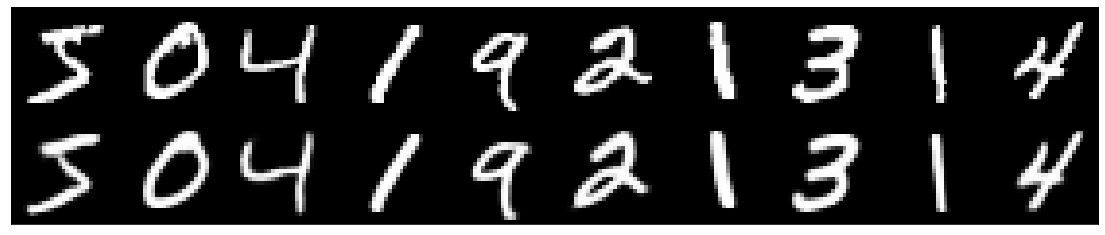

Epoch: [290/600], Batch: [239/240], Progress: 1.00%, Loss: 1593.8119, Minimum loss per epoch: 1173.6025
Epoch: [291/600], Batch: [239/240], Progress: 1.00%, Loss: 1523.0430, Minimum loss per epoch: 1251.2621
Epoch: [292/600], Batch: [239/240], Progress: 1.00%, Loss: 1696.9956, Minimum loss per epoch: 1410.1206
Epoch: [293/600], Batch: [239/240], Progress: 1.00%, Loss: 2144.1780, Minimum loss per epoch: 1541.4877
Epoch: [294/600], Batch: [239/240], Progress: 1.00%, Loss: 2306.4453, Minimum loss per epoch: 1634.4878
Epoch: [295/600], Batch: [239/240], Progress: 1.00%, Loss: 2497.3662, Minimum loss per epoch: 1818.7566
Epoch: [296/600], Batch: [239/240], Progress: 1.00%, Loss: 2597.6121, Minimum loss per epoch: 2045.4734
Epoch: [297/600], Batch: [239/240], Progress: 1.00%, Loss: 2712.5215, Minimum loss per epoch: 2100.5400
Epoch: [298/600], Batch: [239/240], Progress: 1.00%, Loss: 3202.3130, Minimum loss per epoch: 2362.7756
Epoch: [299/600], Batch: [239/240], Progress: 1.00%, Loss: 3238.

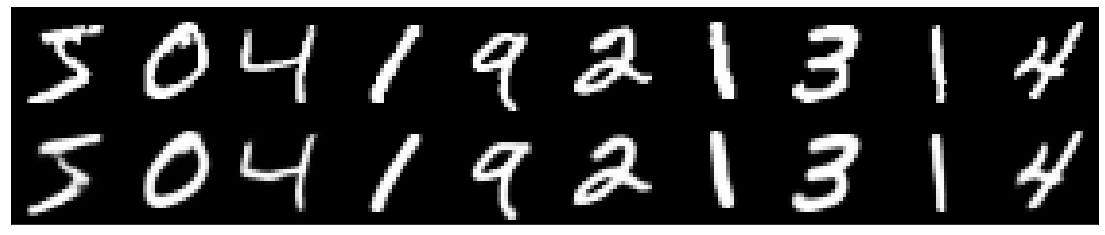

Epoch: [300/600], Batch: [239/240], Progress: 1.00%, Loss: 3686.2109, Minimum loss per epoch: 2887.1394
Epoch: [301/600], Batch: [239/240], Progress: 1.00%, Loss: 4115.7700, Minimum loss per epoch: 3098.9976
Epoch: [302/600], Batch: [239/240], Progress: 1.00%, Loss: 4528.4453, Minimum loss per epoch: 3650.2129
Epoch: [303/600], Batch: [239/240], Progress: 1.00%, Loss: 4710.3823, Minimum loss per epoch: 3645.0847
Epoch: [304/600], Batch: [239/240], Progress: 1.00%, Loss: 5147.5547, Minimum loss per epoch: 4316.5527
Epoch: [305/600], Batch: [239/240], Progress: 1.00%, Loss: 5983.0386, Minimum loss per epoch: 4835.0493
Epoch: [306/600], Batch: [239/240], Progress: 1.00%, Loss: 7305.4448, Minimum loss per epoch: 5106.3799
Epoch: [307/600], Batch: [239/240], Progress: 1.00%, Loss: 7160.9141, Minimum loss per epoch: 5768.0830
Epoch: [308/600], Batch: [239/240], Progress: 1.00%, Loss: 7399.9795, Minimum loss per epoch: 6027.2314
Epoch: [309/600], Batch: [239/240], Progress: 1.00%, Loss: 7173.

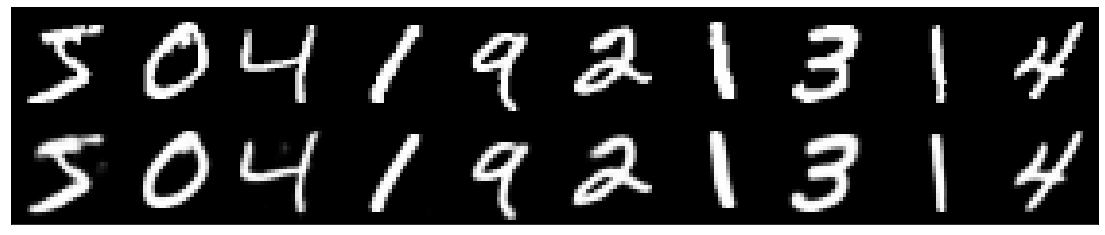

Epoch: [310/600], Batch: [239/240], Progress: 1.00%, Loss: 9170.8154, Minimum loss per epoch: 7739.3506
Epoch: [311/600], Batch: [239/240], Progress: 1.00%, Loss: 10787.0684, Minimum loss per epoch: 7858.9380
Epoch: [312/600], Batch: [239/240], Progress: 1.00%, Loss: 11257.6367, Minimum loss per epoch: 9015.0000
Epoch: [313/600], Batch: [239/240], Progress: 1.00%, Loss: 14249.9316, Minimum loss per epoch: 9839.3652
Epoch: [314/600], Batch: [239/240], Progress: 1.00%, Loss: 12855.9404, Minimum loss per epoch: 11139.3760
Epoch: [315/600], Batch: [239/240], Progress: 1.00%, Loss: 16513.8945, Minimum loss per epoch: 11462.3867
Epoch: [316/600], Batch: [239/240], Progress: 1.00%, Loss: 15523.8682, Minimum loss per epoch: 13156.2480
Epoch: [317/600], Batch: [239/240], Progress: 1.00%, Loss: 19239.2656, Minimum loss per epoch: 14038.2178
Epoch: [318/600], Batch: [239/240], Progress: 1.00%, Loss: 20409.0039, Minimum loss per epoch: 15754.0273
Epoch: [319/600], Batch: [239/240], Progress: 1.00%

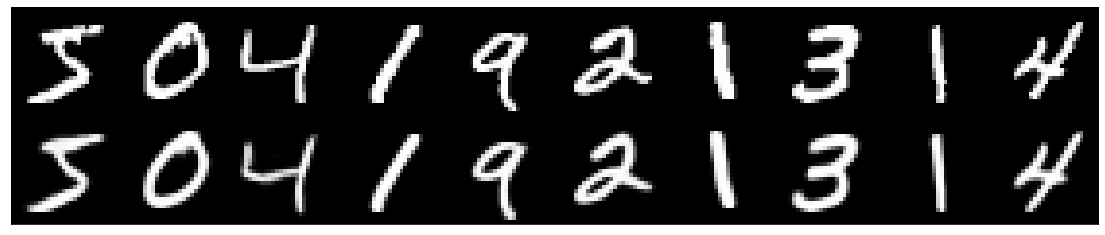

Epoch: [320/600], Batch: [239/240], Progress: 1.00%, Loss: 22435.2266, Minimum loss per epoch: 19244.1973
Epoch: [321/600], Batch: [239/240], Progress: 1.00%, Loss: 27491.9434, Minimum loss per epoch: 20281.8574
Epoch: [322/600], Batch: [239/240], Progress: 1.00%, Loss: 33189.7031, Minimum loss per epoch: 24360.1484
Epoch: [323/600], Batch: [239/240], Progress: 1.00%, Loss: 26258.2891, Minimum loss per epoch: 26258.2891
Epoch: [324/600], Batch: [239/240], Progress: 1.00%, Loss: 42420.7969, Minimum loss per epoch: 27373.5254
Epoch: [325/600], Batch: [239/240], Progress: 1.00%, Loss: 42869.2344, Minimum loss per epoch: 30694.2988
Epoch: [326/600], Batch: [239/240], Progress: 1.00%, Loss: 45436.3555, Minimum loss per epoch: 33877.3047
Epoch: [327/600], Batch: [239/240], Progress: 1.00%, Loss: 47781.6680, Minimum loss per epoch: 39754.1094
Epoch: [328/600], Batch: [239/240], Progress: 1.00%, Loss: 53496.1562, Minimum loss per epoch: 42615.2031
Epoch: [329/600], Batch: [239/240], Progress: 

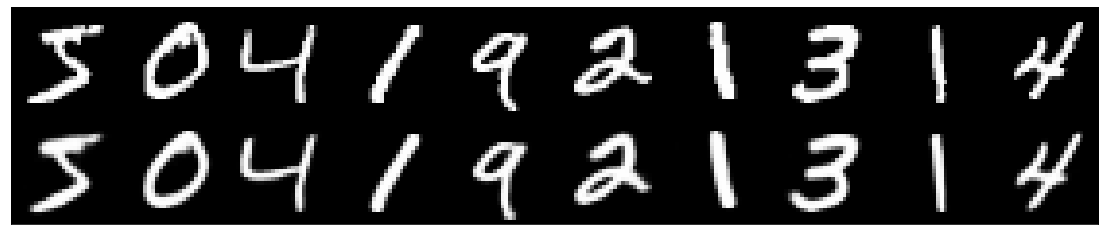

Epoch: [330/600], Batch: [239/240], Progress: 1.00%, Loss: 75446.2812, Minimum loss per epoch: 51608.2891
Epoch: [331/600], Batch: [239/240], Progress: 1.00%, Loss: 66754.9297, Minimum loss per epoch: 55116.8125
Epoch: [332/600], Batch: [239/240], Progress: 1.00%, Loss: 81566.0234, Minimum loss per epoch: 63256.1797
Epoch: [333/600], Batch: [239/240], Progress: 1.00%, Loss: 82718.4609, Minimum loss per epoch: 67881.7266
Epoch: [334/600], Batch: [239/240], Progress: 1.00%, Loss: 94264.6562, Minimum loss per epoch: 77730.9062
Epoch: [335/600], Batch: [239/240], Progress: 1.00%, Loss: 97757.9062, Minimum loss per epoch: 85295.2812
Epoch: [336/600], Batch: [239/240], Progress: 1.00%, Loss: 112597.2656, Minimum loss per epoch: 89285.7109
Epoch: [337/600], Batch: [239/240], Progress: 1.00%, Loss: 129951.0312, Minimum loss per epoch: 96597.0000
Epoch: [338/600], Batch: [239/240], Progress: 1.00%, Loss: 145984.7500, Minimum loss per epoch: 100000.0000
Epoch: [339/600], Batch: [239/240], Progre

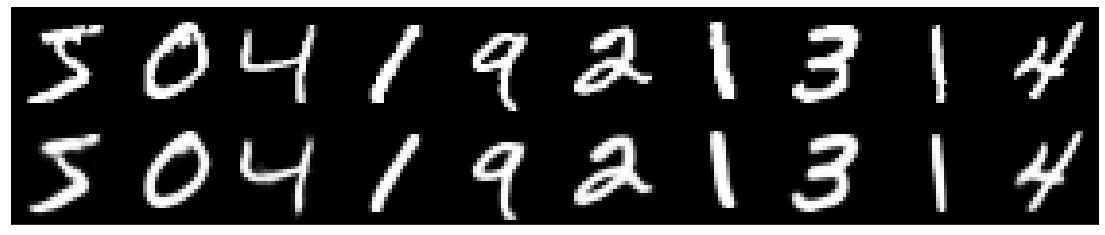

Epoch: [340/600], Batch: [239/240], Progress: 1.00%, Loss: 188991.7969, Minimum loss per epoch: 100000.0000
Epoch: [341/600], Batch: [239/240], Progress: 1.00%, Loss: 186061.2812, Minimum loss per epoch: 100000.0000
Epoch: [342/600], Batch: [239/240], Progress: 1.00%, Loss: 205475.8125, Minimum loss per epoch: 100000.0000
Epoch: [343/600], Batch: [239/240], Progress: 1.00%, Loss: 201731.3594, Minimum loss per epoch: 100000.0000
Epoch: [344/600], Batch: [239/240], Progress: 1.00%, Loss: 218402.1719, Minimum loss per epoch: 100000.0000
Epoch: [345/600], Batch: [239/240], Progress: 1.00%, Loss: 251515.6250, Minimum loss per epoch: 100000.0000
Epoch: [346/600], Batch: [239/240], Progress: 1.00%, Loss: 265610.2188, Minimum loss per epoch: 100000.0000
Epoch: [347/600], Batch: [239/240], Progress: 1.00%, Loss: 318309.1562, Minimum loss per epoch: 100000.0000
Epoch: [348/600], Batch: [239/240], Progress: 1.00%, Loss: 319805.9688, Minimum loss per epoch: 100000.0000
Epoch: [349/600], Batch: [23

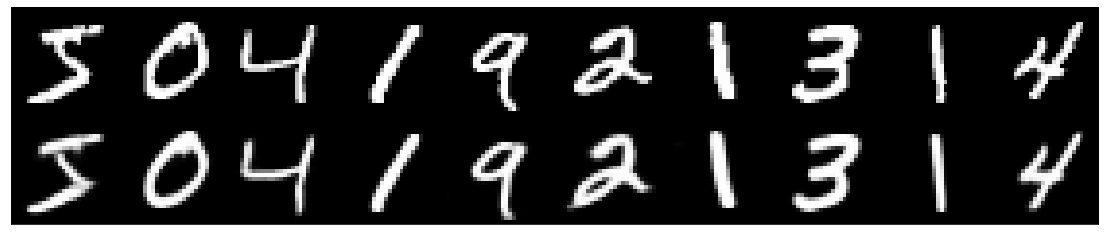

Epoch: [350/600], Batch: [239/240], Progress: 1.00%, Loss: 375958.5625, Minimum loss per epoch: 100000.0000
Epoch: [351/600], Batch: [239/240], Progress: 1.00%, Loss: 521188.8125, Minimum loss per epoch: 100000.0000
Epoch: [352/600], Batch: [239/240], Progress: 1.00%, Loss: 527837.6875, Minimum loss per epoch: 100000.0000
Epoch: [353/600], Batch: [239/240], Progress: 1.00%, Loss: 585450.5000, Minimum loss per epoch: 100000.0000
Epoch: [354/600], Batch: [239/240], Progress: 1.00%, Loss: 565872.6875, Minimum loss per epoch: 100000.0000
Epoch: [355/600], Batch: [239/240], Progress: 1.00%, Loss: 712187.6250, Minimum loss per epoch: 100000.0000
Epoch: [356/600], Batch: [239/240], Progress: 1.00%, Loss: 644786.8125, Minimum loss per epoch: 100000.0000
Epoch: [357/600], Batch: [239/240], Progress: 1.00%, Loss: 1019837.4375, Minimum loss per epoch: 100000.0000
Epoch: [358/600], Batch: [239/240], Progress: 1.00%, Loss: 912955.0000, Minimum loss per epoch: 100000.0000
Epoch: [359/600], Batch: [2

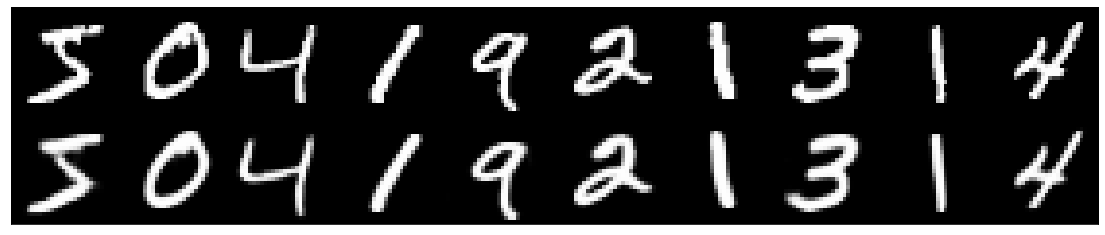

Epoch: [360/600], Batch: [239/240], Progress: 1.00%, Loss: 965383.5625, Minimum loss per epoch: 100000.0000
Epoch: [361/600], Batch: [239/240], Progress: 1.00%, Loss: 1382005.5000, Minimum loss per epoch: 100000.0000
Epoch: [362/600], Batch: [239/240], Progress: 1.00%, Loss: 1335693.7500, Minimum loss per epoch: 100000.0000
Epoch: [363/600], Batch: [239/240], Progress: 1.00%, Loss: 1713820.6250, Minimum loss per epoch: 100000.0000
Epoch: [364/600], Batch: [239/240], Progress: 1.00%, Loss: 1452759.1250, Minimum loss per epoch: 100000.0000
Epoch: [365/600], Batch: [239/240], Progress: 1.00%, Loss: 1873068.0000, Minimum loss per epoch: 100000.0000
Epoch: [366/600], Batch: [239/240], Progress: 1.00%, Loss: 2220422.0000, Minimum loss per epoch: 100000.0000
Epoch: [367/600], Batch: [239/240], Progress: 1.00%, Loss: 2158965.2500, Minimum loss per epoch: 100000.0000
Epoch: [368/600], Batch: [239/240], Progress: 1.00%, Loss: 2222054.7500, Minimum loss per epoch: 100000.0000
Epoch: [369/600], Ba

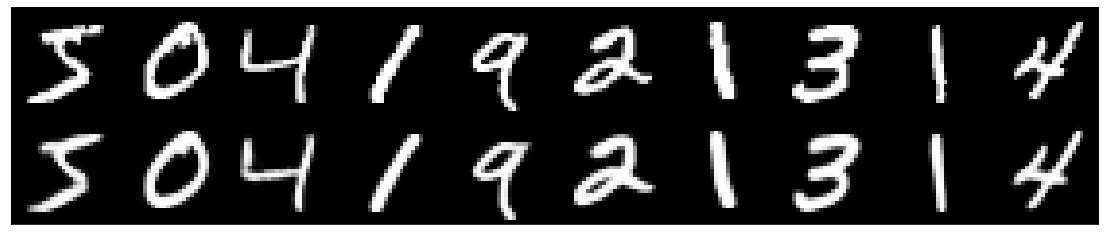

Epoch: [370/600], Batch: [239/240], Progress: 1.00%, Loss: 2791861.0000, Minimum loss per epoch: 100000.0000
Epoch: [371/600], Batch: [239/240], Progress: 1.00%, Loss: 3391427.2500, Minimum loss per epoch: 100000.0000
Epoch: [372/600], Batch: [239/240], Progress: 1.00%, Loss: 3334662.7500, Minimum loss per epoch: 100000.0000
Epoch: [373/600], Batch: [239/240], Progress: 1.00%, Loss: 3200244.0000, Minimum loss per epoch: 100000.0000
Epoch: [374/600], Batch: [239/240], Progress: 1.00%, Loss: 4237091.5000, Minimum loss per epoch: 100000.0000
Epoch: [375/600], Batch: [239/240], Progress: 1.00%, Loss: 4087753.5000, Minimum loss per epoch: 100000.0000
Epoch: [376/600], Batch: [239/240], Progress: 1.00%, Loss: 5091463.5000, Minimum loss per epoch: 100000.0000
Epoch: [377/600], Batch: [239/240], Progress: 1.00%, Loss: 4757539.0000, Minimum loss per epoch: 100000.0000
Epoch: [378/600], Batch: [239/240], Progress: 1.00%, Loss: 6132885.0000, Minimum loss per epoch: 100000.0000
Epoch: [379/600], B

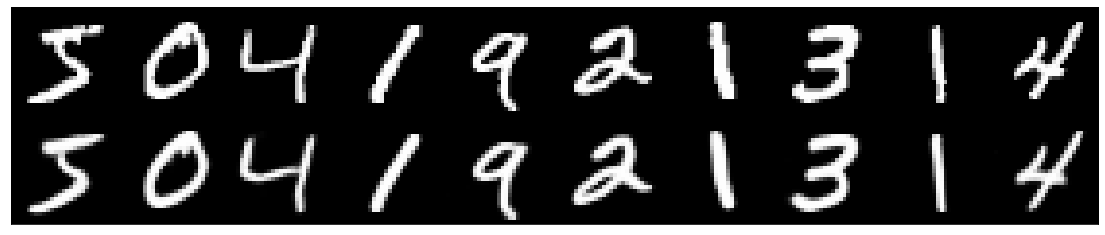

Epoch: [380/600], Batch: [239/240], Progress: 1.00%, Loss: 7281728.0000, Minimum loss per epoch: 100000.0000
Epoch: [381/600], Batch: [239/240], Progress: 1.00%, Loss: 6926428.5000, Minimum loss per epoch: 100000.0000
Epoch: [382/600], Batch: [239/240], Progress: 1.00%, Loss: 8595519.0000, Minimum loss per epoch: 100000.0000
Epoch: [383/600], Batch: [239/240], Progress: 1.00%, Loss: 8530771.0000, Minimum loss per epoch: 100000.0000
Epoch: [384/600], Batch: [239/240], Progress: 1.00%, Loss: 12649013.0000, Minimum loss per epoch: 100000.0000
Epoch: [385/600], Batch: [239/240], Progress: 1.00%, Loss: 12299749.0000, Minimum loss per epoch: 100000.0000
Epoch: [386/600], Batch: [239/240], Progress: 1.00%, Loss: 13333297.0000, Minimum loss per epoch: 100000.0000
Epoch: [387/600], Batch: [239/240], Progress: 1.00%, Loss: 16647464.0000, Minimum loss per epoch: 100000.0000
Epoch: [388/600], Batch: [239/240], Progress: 1.00%, Loss: 16394437.0000, Minimum loss per epoch: 100000.0000
Epoch: [389/60

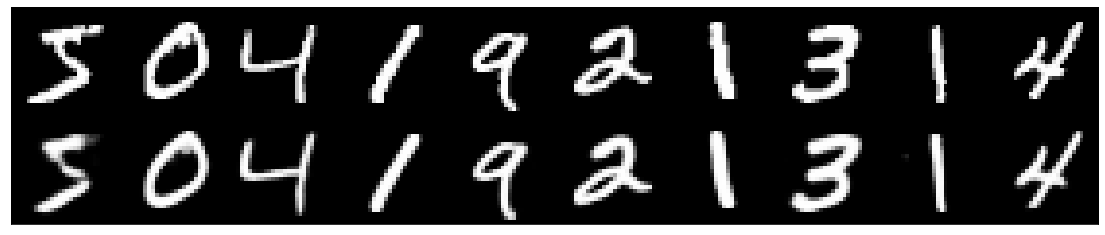

Epoch: [390/600], Batch: [239/240], Progress: 1.00%, Loss: 17053816.0000, Minimum loss per epoch: 100000.0000
Epoch: [391/600], Batch: [239/240], Progress: 1.00%, Loss: 22699590.0000, Minimum loss per epoch: 100000.0000
Epoch: [392/600], Batch: [239/240], Progress: 1.00%, Loss: 20127700.0000, Minimum loss per epoch: 100000.0000
Epoch: [393/600], Batch: [239/240], Progress: 1.00%, Loss: 27704050.0000, Minimum loss per epoch: 100000.0000
Epoch: [394/600], Batch: [239/240], Progress: 1.00%, Loss: 23441632.0000, Minimum loss per epoch: 100000.0000
Epoch: [395/600], Batch: [239/240], Progress: 1.00%, Loss: 32803888.0000, Minimum loss per epoch: 100000.0000
Epoch: [396/600], Batch: [239/240], Progress: 1.00%, Loss: 27354056.0000, Minimum loss per epoch: 100000.0000
Epoch: [397/600], Batch: [239/240], Progress: 1.00%, Loss: 36413704.0000, Minimum loss per epoch: 100000.0000
Epoch: [398/600], Batch: [239/240], Progress: 1.00%, Loss: 41925540.0000, Minimum loss per epoch: 100000.0000
Epoch: [39

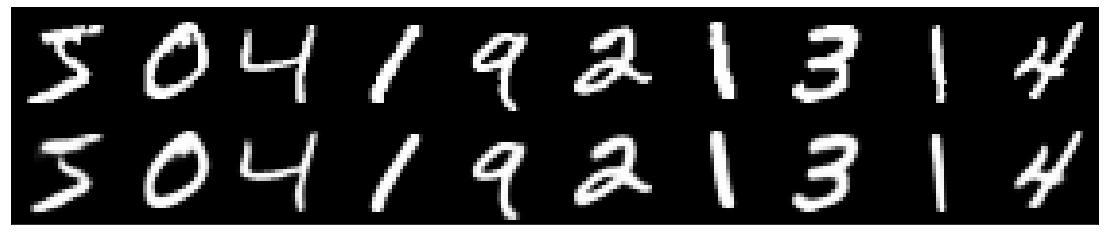

Epoch: [400/600], Batch: [239/240], Progress: 1.00%, Loss: 53617012.0000, Minimum loss per epoch: 100000.0000
Epoch: [401/600], Batch: [239/240], Progress: 1.00%, Loss: 60645104.0000, Minimum loss per epoch: 100000.0000
Epoch: [402/600], Batch: [239/240], Progress: 1.00%, Loss: 56296040.0000, Minimum loss per epoch: 100000.0000
Epoch: [403/600], Batch: [239/240], Progress: 1.00%, Loss: 63747408.0000, Minimum loss per epoch: 100000.0000
Epoch: [404/600], Batch: [239/240], Progress: 1.00%, Loss: 85800416.0000, Minimum loss per epoch: 100000.0000
Epoch: [405/600], Batch: [239/240], Progress: 1.00%, Loss: 78321696.0000, Minimum loss per epoch: 100000.0000
Epoch: [406/600], Batch: [239/240], Progress: 1.00%, Loss: 85979672.0000, Minimum loss per epoch: 100000.0000
Epoch: [407/600], Batch: [239/240], Progress: 1.00%, Loss: 89187696.0000, Minimum loss per epoch: 100000.0000
Epoch: [408/600], Batch: [239/240], Progress: 1.00%, Loss: 114127136.0000, Minimum loss per epoch: 100000.0000
Epoch: [4

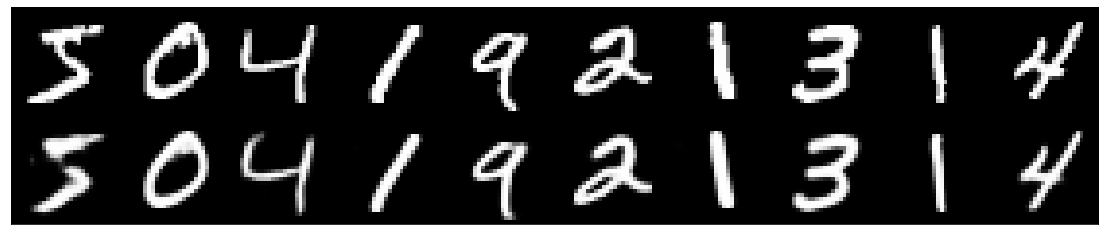

Epoch: [410/600], Batch: [239/240], Progress: 1.00%, Loss: 125002960.0000, Minimum loss per epoch: 100000.0000
Epoch: [411/600], Batch: [239/240], Progress: 1.00%, Loss: 144745664.0000, Minimum loss per epoch: 100000.0000
Epoch: [412/600], Batch: [239/240], Progress: 1.00%, Loss: 164688304.0000, Minimum loss per epoch: 100000.0000
Epoch: [413/600], Batch: [239/240], Progress: 1.00%, Loss: 179977152.0000, Minimum loss per epoch: 100000.0000
Epoch: [414/600], Batch: [239/240], Progress: 1.00%, Loss: 193625200.0000, Minimum loss per epoch: 100000.0000
Epoch: [415/600], Batch: [239/240], Progress: 1.00%, Loss: 232738720.0000, Minimum loss per epoch: 100000.0000
Epoch: [416/600], Batch: [239/240], Progress: 1.00%, Loss: 214485824.0000, Minimum loss per epoch: 100000.0000
Epoch: [417/600], Batch: [239/240], Progress: 1.00%, Loss: 289967712.0000, Minimum loss per epoch: 100000.0000
Epoch: [418/600], Batch: [239/240], Progress: 1.00%, Loss: 273291968.0000, Minimum loss per epoch: 100000.0000
E

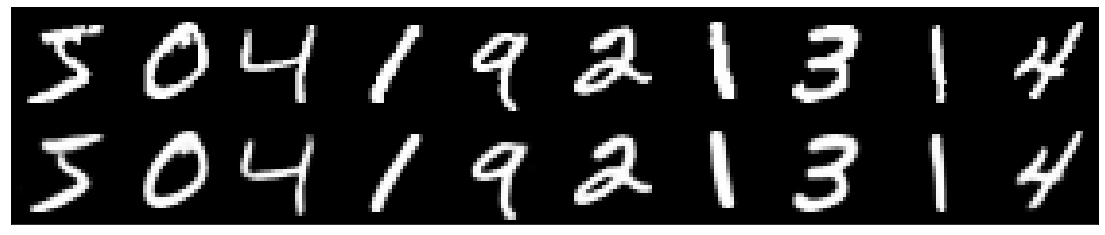

Epoch: [420/600], Batch: [239/240], Progress: 1.00%, Loss: 289165952.0000, Minimum loss per epoch: 100000.0000
Epoch: [421/600], Batch: [239/240], Progress: 1.00%, Loss: 385291104.0000, Minimum loss per epoch: 100000.0000
Epoch: [422/600], Batch: [239/240], Progress: 1.00%, Loss: 324666656.0000, Minimum loss per epoch: 100000.0000
Epoch: [423/600], Batch: [239/240], Progress: 1.00%, Loss: 421175232.0000, Minimum loss per epoch: 100000.0000
Epoch: [424/600], Batch: [239/240], Progress: 1.00%, Loss: 505302592.0000, Minimum loss per epoch: 100000.0000
Epoch: [425/600], Batch: [239/240], Progress: 1.00%, Loss: 531315456.0000, Minimum loss per epoch: 100000.0000
Epoch: [426/600], Batch: [239/240], Progress: 1.00%, Loss: 516792384.0000, Minimum loss per epoch: 100000.0000
Epoch: [427/600], Batch: [239/240], Progress: 1.00%, Loss: 705817408.0000, Minimum loss per epoch: 100000.0000
Epoch: [428/600], Batch: [239/240], Progress: 1.00%, Loss: 727095872.0000, Minimum loss per epoch: 100000.0000
E

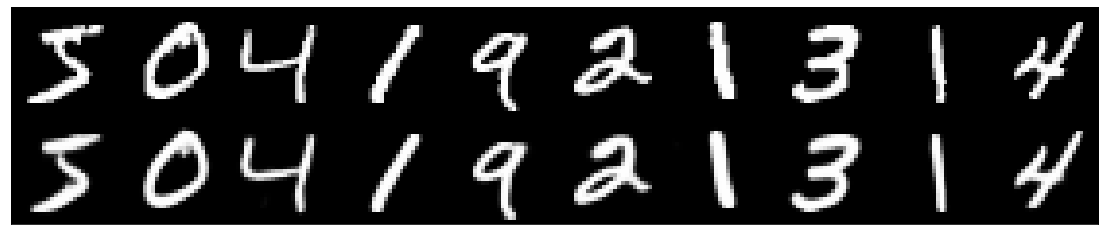

Epoch: [430/600], Batch: [239/240], Progress: 1.00%, Loss: 811418368.0000, Minimum loss per epoch: 100000.0000
Epoch: [431/600], Batch: [239/240], Progress: 1.00%, Loss: 867943360.0000, Minimum loss per epoch: 100000.0000
Epoch: [432/600], Batch: [239/240], Progress: 1.00%, Loss: 1235510016.0000, Minimum loss per epoch: 100000.0000
Epoch: [433/600], Batch: [239/240], Progress: 1.00%, Loss: 975773440.0000, Minimum loss per epoch: 100000.0000
Epoch: [434/600], Batch: [239/240], Progress: 1.00%, Loss: 1125725952.0000, Minimum loss per epoch: 100000.0000
Epoch: [435/600], Batch: [239/240], Progress: 1.00%, Loss: 1203664768.0000, Minimum loss per epoch: 100000.0000
Epoch: [436/600], Batch: [239/240], Progress: 1.00%, Loss: 1495826176.0000, Minimum loss per epoch: 100000.0000
Epoch: [437/600], Batch: [239/240], Progress: 1.00%, Loss: 1688210432.0000, Minimum loss per epoch: 100000.0000
Epoch: [438/600], Batch: [239/240], Progress: 1.00%, Loss: 1949308160.0000, Minimum loss per epoch: 100000.

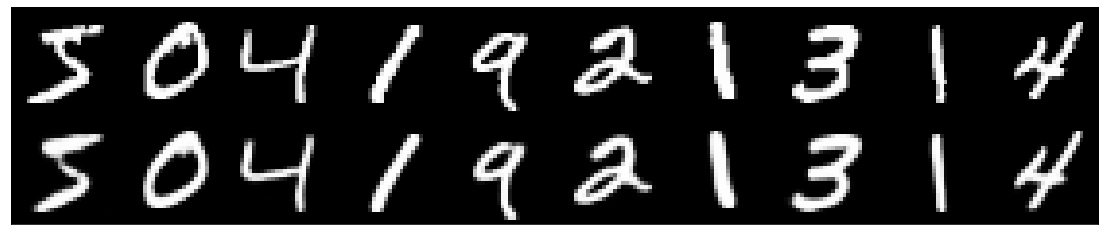

Epoch: [440/600], Batch: [239/240], Progress: 1.00%, Loss: 2378300160.0000, Minimum loss per epoch: 100000.0000
Epoch: [441/600], Batch: [239/240], Progress: 1.00%, Loss: 2618248960.0000, Minimum loss per epoch: 100000.0000
Epoch: [442/600], Batch: [239/240], Progress: 1.00%, Loss: 3074398464.0000, Minimum loss per epoch: 100000.0000
Epoch: [443/600], Batch: [239/240], Progress: 1.00%, Loss: 2942014720.0000, Minimum loss per epoch: 100000.0000
Epoch: [444/600], Batch: [239/240], Progress: 1.00%, Loss: 3144759296.0000, Minimum loss per epoch: 100000.0000
Epoch: [445/600], Batch: [239/240], Progress: 1.00%, Loss: 3859006976.0000, Minimum loss per epoch: 100000.0000
Epoch: [446/600], Batch: [239/240], Progress: 1.00%, Loss: 3642590976.0000, Minimum loss per epoch: 100000.0000
Epoch: [447/600], Batch: [239/240], Progress: 1.00%, Loss: 3968498176.0000, Minimum loss per epoch: 100000.0000
Epoch: [448/600], Batch: [239/240], Progress: 1.00%, Loss: 4359321088.0000, Minimum loss per epoch: 1000

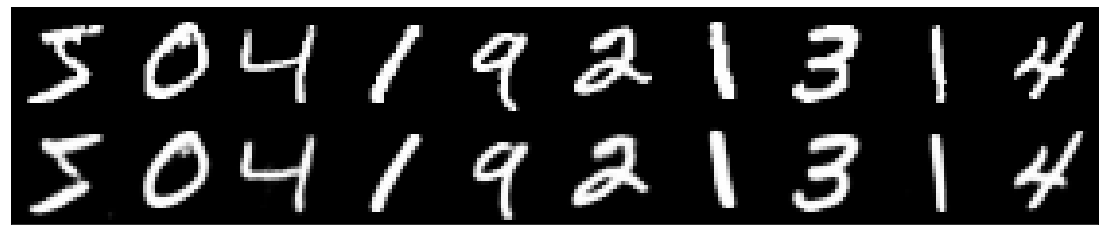

Epoch: [450/600], Batch: [239/240], Progress: 1.00%, Loss: 5671425536.0000, Minimum loss per epoch: 100000.0000
Epoch: [451/600], Batch: [239/240], Progress: 1.00%, Loss: 6064732672.0000, Minimum loss per epoch: 100000.0000
Epoch: [452/600], Batch: [239/240], Progress: 1.00%, Loss: 6202246144.0000, Minimum loss per epoch: 100000.0000
Epoch: [453/600], Batch: [239/240], Progress: 1.00%, Loss: 7708317184.0000, Minimum loss per epoch: 100000.0000
Epoch: [454/600], Batch: [239/240], Progress: 1.00%, Loss: 9477395456.0000, Minimum loss per epoch: 100000.0000
Epoch: [455/600], Batch: [239/240], Progress: 1.00%, Loss: 9498714112.0000, Minimum loss per epoch: 100000.0000
Epoch: [456/600], Batch: [239/240], Progress: 1.00%, Loss: 10623704064.0000, Minimum loss per epoch: 100000.0000
Epoch: [457/600], Batch: [239/240], Progress: 1.00%, Loss: 12716220416.0000, Minimum loss per epoch: 100000.0000
Epoch: [458/600], Batch: [239/240], Progress: 1.00%, Loss: 13008017408.0000, Minimum loss per epoch: 1

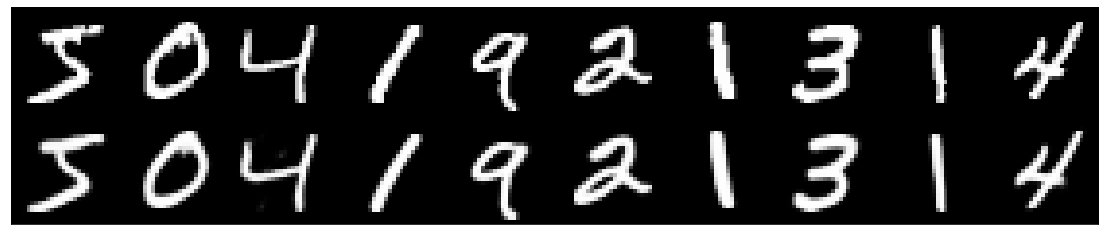

Epoch: [460/600], Batch: [239/240], Progress: 1.00%, Loss: 13857336320.0000, Minimum loss per epoch: 100000.0000
Epoch: [461/600], Batch: [239/240], Progress: 1.00%, Loss: 17204824064.0000, Minimum loss per epoch: 100000.0000
Epoch: [462/600], Batch: [239/240], Progress: 1.00%, Loss: 17614000128.0000, Minimum loss per epoch: 100000.0000
Epoch: [463/600], Batch: [239/240], Progress: 1.00%, Loss: 17893115904.0000, Minimum loss per epoch: 100000.0000
Epoch: [464/600], Batch: [239/240], Progress: 1.00%, Loss: 26148182016.0000, Minimum loss per epoch: 100000.0000
Epoch: [465/600], Batch: [239/240], Progress: 1.00%, Loss: 25298393088.0000, Minimum loss per epoch: 100000.0000
Epoch: [466/600], Batch: [239/240], Progress: 1.00%, Loss: 23864066048.0000, Minimum loss per epoch: 100000.0000
Epoch: [467/600], Batch: [239/240], Progress: 1.00%, Loss: 28413911040.0000, Minimum loss per epoch: 100000.0000
Epoch: [468/600], Batch: [239/240], Progress: 1.00%, Loss: 35350167552.0000, Minimum loss per ep

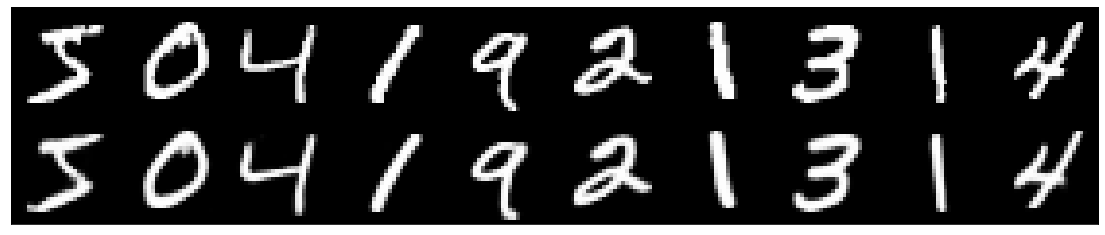

Epoch: [470/600], Batch: [239/240], Progress: 1.00%, Loss: 38415638528.0000, Minimum loss per epoch: 100000.0000
Epoch: [471/600], Batch: [239/240], Progress: 1.00%, Loss: 44596293632.0000, Minimum loss per epoch: 100000.0000
Epoch: [472/600], Batch: [239/240], Progress: 1.00%, Loss: 55890341888.0000, Minimum loss per epoch: 100000.0000
Epoch: [473/600], Batch: [239/240], Progress: 1.00%, Loss: 50862342144.0000, Minimum loss per epoch: 100000.0000
Epoch: [474/600], Batch: [239/240], Progress: 1.00%, Loss: 53345218560.0000, Minimum loss per epoch: 100000.0000
Epoch: [475/600], Batch: [239/240], Progress: 1.00%, Loss: 57100812288.0000, Minimum loss per epoch: 100000.0000
Epoch: [476/600], Batch: [239/240], Progress: 1.00%, Loss: 61893812224.0000, Minimum loss per epoch: 100000.0000
Epoch: [477/600], Batch: [239/240], Progress: 1.00%, Loss: 93755285504.0000, Minimum loss per epoch: 100000.0000
Epoch: [478/600], Batch: [239/240], Progress: 1.00%, Loss: 88314593280.0000, Minimum loss per ep

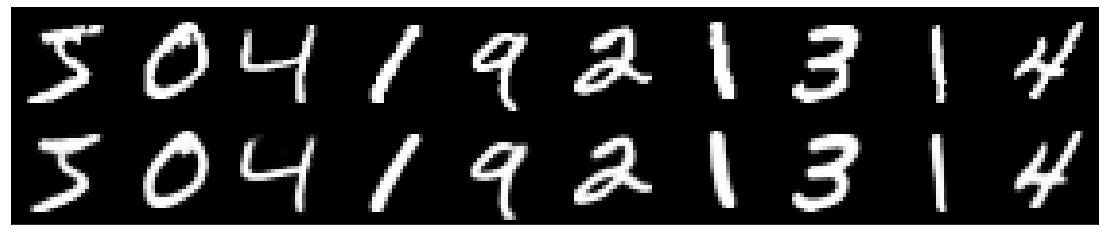

Epoch: [480/600], Batch: [239/240], Progress: 1.00%, Loss: 98505318400.0000, Minimum loss per epoch: 100000.0000
Epoch: [481/600], Batch: [239/240], Progress: 1.00%, Loss: 114661523456.0000, Minimum loss per epoch: 100000.0000
Epoch: [482/600], Batch: [239/240], Progress: 1.00%, Loss: 127004983296.0000, Minimum loss per epoch: 100000.0000
Epoch: [483/600], Batch: [239/240], Progress: 1.00%, Loss: 159214616576.0000, Minimum loss per epoch: 100000.0000
Epoch: [484/600], Batch: [239/240], Progress: 1.00%, Loss: 169654714368.0000, Minimum loss per epoch: 100000.0000
Epoch: [485/600], Batch: [239/240], Progress: 1.00%, Loss: 157616881664.0000, Minimum loss per epoch: 100000.0000
Epoch: [486/600], Batch: [239/240], Progress: 1.00%, Loss: 197584846848.0000, Minimum loss per epoch: 100000.0000
Epoch: [487/600], Batch: [239/240], Progress: 1.00%, Loss: 222956552192.0000, Minimum loss per epoch: 100000.0000
Epoch: [488/600], Batch: [239/240], Progress: 1.00%, Loss: 229060706304.0000, Minimum los

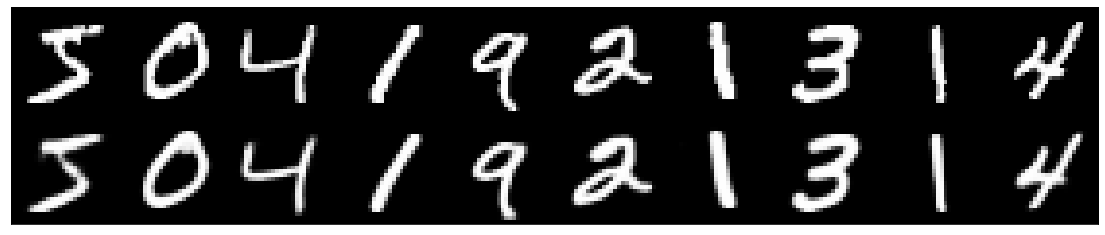

Epoch: [490/600], Batch: [239/240], Progress: 1.00%, Loss: 273893801984.0000, Minimum loss per epoch: 100000.0000
Epoch: [491/600], Batch: [239/240], Progress: 1.00%, Loss: 283113062400.0000, Minimum loss per epoch: 100000.0000
Epoch: [492/600], Batch: [239/240], Progress: 1.00%, Loss: 292424155136.0000, Minimum loss per epoch: 100000.0000
Epoch: [493/600], Batch: [239/240], Progress: 1.00%, Loss: 342671458304.0000, Minimum loss per epoch: 100000.0000
Epoch: [494/600], Batch: [239/240], Progress: 1.00%, Loss: 405364211712.0000, Minimum loss per epoch: 100000.0000
Epoch: [495/600], Batch: [239/240], Progress: 1.00%, Loss: 460038897664.0000, Minimum loss per epoch: 100000.0000
Epoch: [496/600], Batch: [239/240], Progress: 1.00%, Loss: 490919821312.0000, Minimum loss per epoch: 100000.0000
Epoch: [497/600], Batch: [239/240], Progress: 1.00%, Loss: 480621756416.0000, Minimum loss per epoch: 100000.0000
Epoch: [498/600], Batch: [239/240], Progress: 1.00%, Loss: 544432488448.0000, Minimum lo

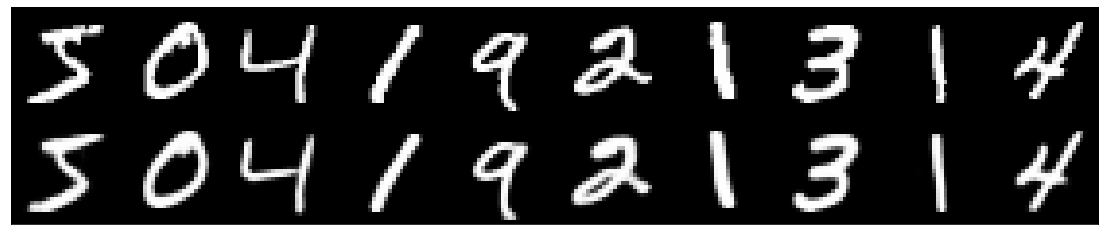

Epoch: [500/600], Batch: [239/240], Progress: 1.00%, Loss: 621658243072.0000, Minimum loss per epoch: 100000.0000
Epoch: [501/600], Batch: [239/240], Progress: 1.00%, Loss: 681296265216.0000, Minimum loss per epoch: 100000.0000
Epoch: [502/600], Batch: [239/240], Progress: 1.00%, Loss: 854369173504.0000, Minimum loss per epoch: 100000.0000
Epoch: [503/600], Batch: [239/240], Progress: 1.00%, Loss: 953560006656.0000, Minimum loss per epoch: 100000.0000
Epoch: [504/600], Batch: [239/240], Progress: 1.00%, Loss: 973887832064.0000, Minimum loss per epoch: 100000.0000
Epoch: [505/600], Batch: [239/240], Progress: 1.00%, Loss: 956129345536.0000, Minimum loss per epoch: 100000.0000
Epoch: [506/600], Batch: [239/240], Progress: 1.00%, Loss: 1160663793664.0000, Minimum loss per epoch: 100000.0000
Epoch: [507/600], Batch: [239/240], Progress: 1.00%, Loss: 1266002034688.0000, Minimum loss per epoch: 100000.0000
Epoch: [508/600], Batch: [239/240], Progress: 1.00%, Loss: 1563641774080.0000, Minimum

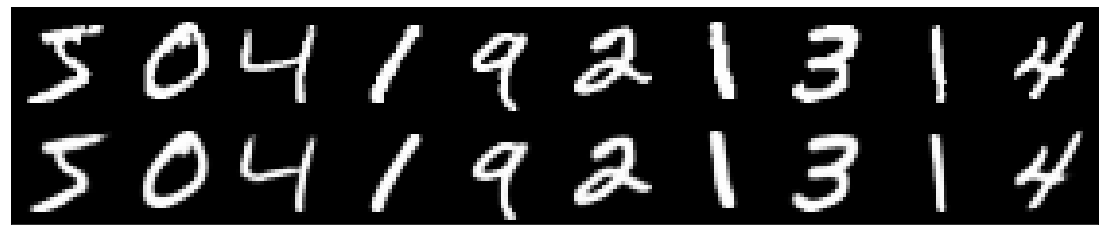

Epoch: [510/600], Batch: [239/240], Progress: 1.00%, Loss: 1690880311296.0000, Minimum loss per epoch: 100000.0000
Epoch: [511/600], Batch: [239/240], Progress: 1.00%, Loss: 1742436433920.0000, Minimum loss per epoch: 100000.0000
Epoch: [512/600], Batch: [239/240], Progress: 1.00%, Loss: 1942878552064.0000, Minimum loss per epoch: 100000.0000
Epoch: [513/600], Batch: [239/240], Progress: 1.00%, Loss: 2581356085248.0000, Minimum loss per epoch: 100000.0000
Epoch: [514/600], Batch: [239/240], Progress: 1.00%, Loss: 2309064491008.0000, Minimum loss per epoch: 100000.0000
Epoch: [515/600], Batch: [239/240], Progress: 1.00%, Loss: 2817370095616.0000, Minimum loss per epoch: 100000.0000
Epoch: [516/600], Batch: [239/240], Progress: 1.00%, Loss: 3523749347328.0000, Minimum loss per epoch: 100000.0000
Epoch: [517/600], Batch: [239/240], Progress: 1.00%, Loss: 3204754702336.0000, Minimum loss per epoch: 100000.0000
Epoch: [518/600], Batch: [239/240], Progress: 1.00%, Loss: 3916744359936.0000, M

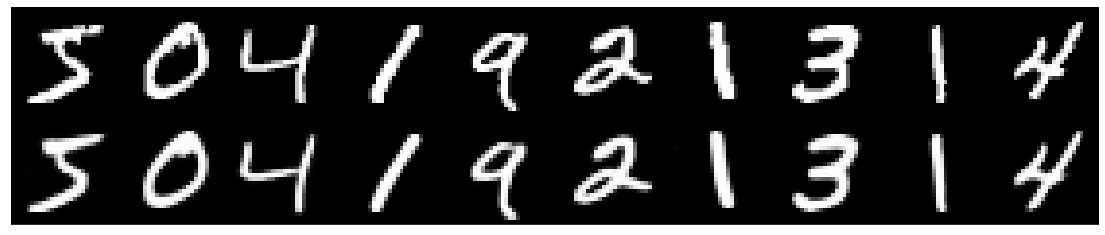

Epoch: [520/600], Batch: [239/240], Progress: 1.00%, Loss: 4122597130240.0000, Minimum loss per epoch: 100000.0000
Epoch: [521/600], Batch: [239/240], Progress: 1.00%, Loss: 4773648531456.0000, Minimum loss per epoch: 100000.0000
Epoch: [522/600], Batch: [239/240], Progress: 1.00%, Loss: 6068583792640.0000, Minimum loss per epoch: 100000.0000
Epoch: [523/600], Batch: [239/240], Progress: 1.00%, Loss: 6340453335040.0000, Minimum loss per epoch: 100000.0000
Epoch: [524/600], Batch: [239/240], Progress: 1.00%, Loss: 6126314192896.0000, Minimum loss per epoch: 100000.0000
Epoch: [525/600], Batch: [239/240], Progress: 1.00%, Loss: 8306311561216.0000, Minimum loss per epoch: 100000.0000
Epoch: [526/600], Batch: [239/240], Progress: 1.00%, Loss: 9309235707904.0000, Minimum loss per epoch: 100000.0000
Epoch: [527/600], Batch: [239/240], Progress: 1.00%, Loss: 9401731645440.0000, Minimum loss per epoch: 100000.0000
Epoch: [528/600], Batch: [239/240], Progress: 1.00%, Loss: 9412555046912.0000, M

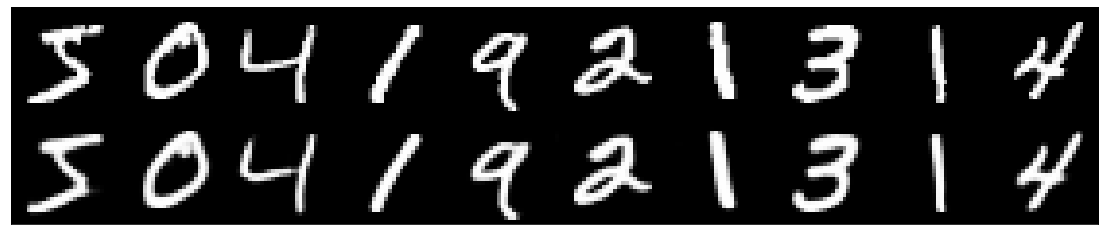

Epoch: [530/600], Batch: [239/240], Progress: 1.00%, Loss: 12181908226048.0000, Minimum loss per epoch: 100000.0000
Epoch: [531/600], Batch: [239/240], Progress: 1.00%, Loss: 13296399810560.0000, Minimum loss per epoch: 100000.0000
Epoch: [532/600], Batch: [239/240], Progress: 1.00%, Loss: 14182187532288.0000, Minimum loss per epoch: 100000.0000
Epoch: [533/600], Batch: [239/240], Progress: 1.00%, Loss: 16944857088000.0000, Minimum loss per epoch: 100000.0000
Epoch: [534/600], Batch: [239/240], Progress: 1.00%, Loss: 16431709159424.0000, Minimum loss per epoch: 100000.0000
Epoch: [535/600], Batch: [239/240], Progress: 1.00%, Loss: 23742103158784.0000, Minimum loss per epoch: 100000.0000
Epoch: [536/600], Batch: [239/240], Progress: 1.00%, Loss: 19252977336320.0000, Minimum loss per epoch: 100000.0000
Epoch: [537/600], Batch: [239/240], Progress: 1.00%, Loss: 21912140906496.0000, Minimum loss per epoch: 100000.0000
Epoch: [538/600], Batch: [239/240], Progress: 1.00%, Loss: 2434920559411

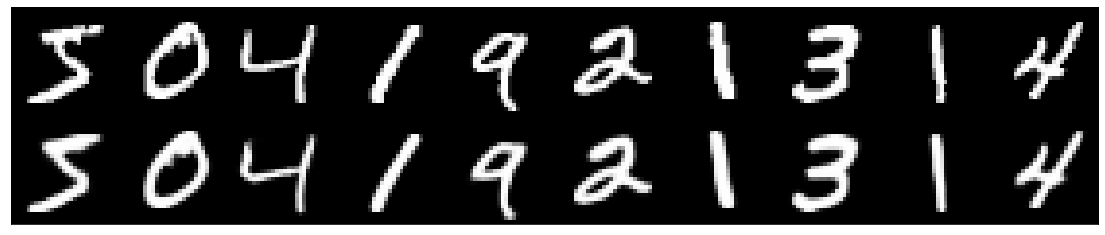

Epoch: [540/600], Batch: [239/240], Progress: 1.00%, Loss: 32638807048192.0000, Minimum loss per epoch: 100000.0000
Epoch: [541/600], Batch: [239/240], Progress: 1.00%, Loss: 34023885766656.0000, Minimum loss per epoch: 100000.0000
Epoch: [542/600], Batch: [239/240], Progress: 1.00%, Loss: 34912470040576.0000, Minimum loss per epoch: 100000.0000
Epoch: [543/600], Batch: [239/240], Progress: 1.00%, Loss: 42752133824512.0000, Minimum loss per epoch: 100000.0000
Epoch: [544/600], Batch: [239/240], Progress: 1.00%, Loss: 40269906968576.0000, Minimum loss per epoch: 100000.0000
Epoch: [545/600], Batch: [239/240], Progress: 1.00%, Loss: 48441883361280.0000, Minimum loss per epoch: 100000.0000
Epoch: [546/600], Batch: [239/240], Progress: 1.00%, Loss: 51722940579840.0000, Minimum loss per epoch: 100000.0000
Epoch: [547/600], Batch: [239/240], Progress: 1.00%, Loss: 49718667247616.0000, Minimum loss per epoch: 100000.0000
Epoch: [548/600], Batch: [239/240], Progress: 1.00%, Loss: 6092249209241

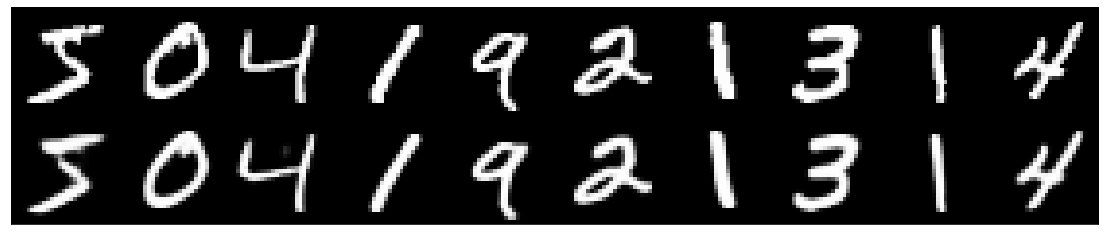

Epoch: [550/600], Batch: [239/240], Progress: 1.00%, Loss: 75822169849856.0000, Minimum loss per epoch: 100000.0000
Epoch: [551/600], Batch: [239/240], Progress: 1.00%, Loss: 89187772530688.0000, Minimum loss per epoch: 100000.0000
Epoch: [552/600], Batch: [239/240], Progress: 1.00%, Loss: 91252737441792.0000, Minimum loss per epoch: 100000.0000
Epoch: [553/600], Batch: [239/240], Progress: 1.00%, Loss: 111469987364864.0000, Minimum loss per epoch: 100000.0000
Epoch: [554/600], Batch: [239/240], Progress: 1.00%, Loss: 118858379689984.0000, Minimum loss per epoch: 100000.0000
Epoch: [555/600], Batch: [239/240], Progress: 1.00%, Loss: 134092519636992.0000, Minimum loss per epoch: 100000.0000
Epoch: [556/600], Batch: [239/240], Progress: 1.00%, Loss: 156342127951872.0000, Minimum loss per epoch: 100000.0000
Epoch: [557/600], Batch: [239/240], Progress: 1.00%, Loss: 149591546658816.0000, Minimum loss per epoch: 100000.0000
Epoch: [558/600], Batch: [239/240], Progress: 1.00%, Loss: 17070669

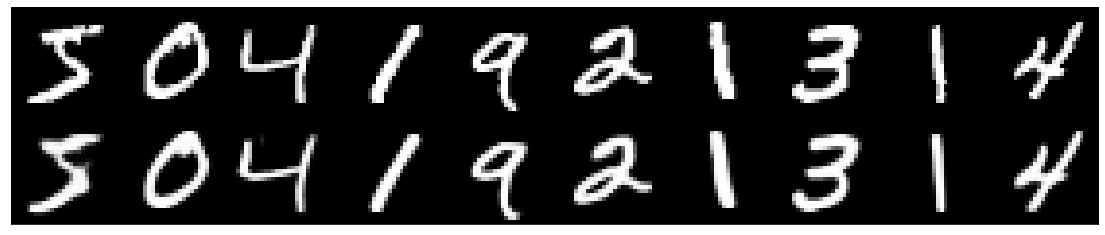

Epoch: [560/600], Batch: [239/240], Progress: 1.00%, Loss: 212495872557056.0000, Minimum loss per epoch: 100000.0000
Epoch: [561/600], Batch: [239/240], Progress: 1.00%, Loss: 211357236461568.0000, Minimum loss per epoch: 100000.0000
Epoch: [562/600], Batch: [239/240], Progress: 1.00%, Loss: 250447008890880.0000, Minimum loss per epoch: 100000.0000
Epoch: [563/600], Batch: [239/240], Progress: 1.00%, Loss: 243977311748096.0000, Minimum loss per epoch: 100000.0000
Epoch: [564/600], Batch: [239/240], Progress: 1.00%, Loss: 311392913588224.0000, Minimum loss per epoch: 100000.0000
Epoch: [565/600], Batch: [239/240], Progress: 1.00%, Loss: 354289536991232.0000, Minimum loss per epoch: 100000.0000
Epoch: [566/600], Batch: [239/240], Progress: 1.00%, Loss: 330350362361856.0000, Minimum loss per epoch: 100000.0000
Epoch: [567/600], Batch: [239/240], Progress: 1.00%, Loss: 314998471524352.0000, Minimum loss per epoch: 100000.0000
Epoch: [568/600], Batch: [239/240], Progress: 1.00%, Loss: 45241

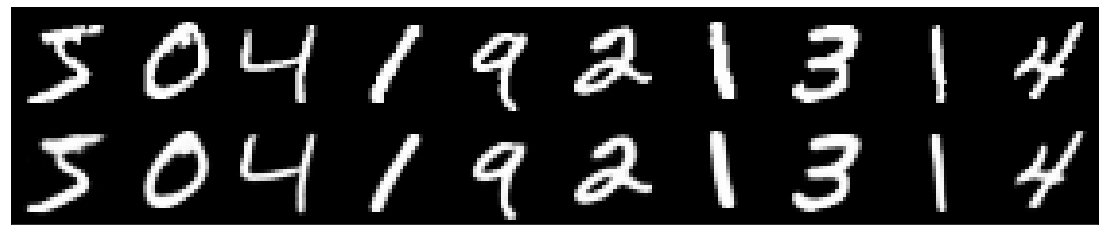

Epoch: [570/600], Batch: [239/240], Progress: 1.00%, Loss: 499769206112256.0000, Minimum loss per epoch: 100000.0000
Epoch: [571/600], Batch: [239/240], Progress: 1.00%, Loss: 565651286523904.0000, Minimum loss per epoch: 100000.0000
Epoch: [572/600], Batch: [239/240], Progress: 1.00%, Loss: 763238438404096.0000, Minimum loss per epoch: 100000.0000
Epoch: [573/600], Batch: [239/240], Progress: 1.00%, Loss: 879331605741568.0000, Minimum loss per epoch: 100000.0000
Epoch: [574/600], Batch: [239/240], Progress: 1.00%, Loss: 826994543558656.0000, Minimum loss per epoch: 100000.0000
Epoch: [575/600], Batch: [239/240], Progress: 1.00%, Loss: 716948153303040.0000, Minimum loss per epoch: 100000.0000
Epoch: [576/600], Batch: [239/240], Progress: 1.00%, Loss: 910354557173760.0000, Minimum loss per epoch: 100000.0000
Epoch: [577/600], Batch: [239/240], Progress: 1.00%, Loss: 1118412705103872.0000, Minimum loss per epoch: 100000.0000
Epoch: [578/600], Batch: [239/240], Progress: 1.00%, Loss: 1080

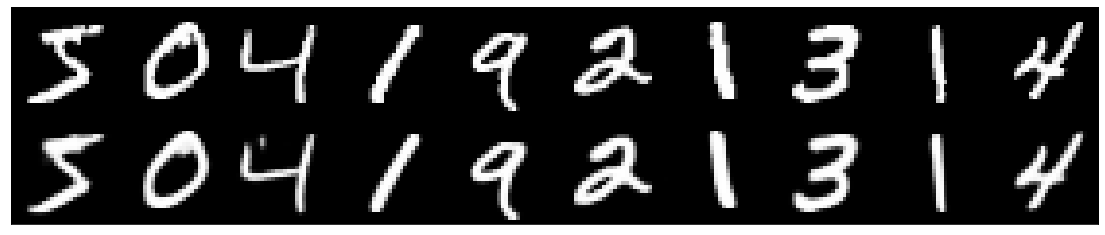

Epoch: [580/600], Batch: [239/240], Progress: 1.00%, Loss: 1378731075567616.0000, Minimum loss per epoch: 100000.0000
Epoch: [581/600], Batch: [239/240], Progress: 1.00%, Loss: 1449234574344192.0000, Minimum loss per epoch: 100000.0000
Epoch: [582/600], Batch: [239/240], Progress: 1.00%, Loss: 1709669311578112.0000, Minimum loss per epoch: 100000.0000
Epoch: [583/600], Batch: [239/240], Progress: 1.00%, Loss: 2125576898871296.0000, Minimum loss per epoch: 100000.0000
Epoch: [584/600], Batch: [239/240], Progress: 1.00%, Loss: 2072512980582400.0000, Minimum loss per epoch: 100000.0000
Epoch: [585/600], Batch: [239/240], Progress: 1.00%, Loss: 2062532281892864.0000, Minimum loss per epoch: 100000.0000
Epoch: [586/600], Batch: [239/240], Progress: 1.00%, Loss: 2073173197586432.0000, Minimum loss per epoch: 100000.0000
Epoch: [587/600], Batch: [239/240], Progress: 1.00%, Loss: 2403754951311360.0000, Minimum loss per epoch: 100000.0000
Epoch: [588/600], Batch: [239/240], Progress: 1.00%, Los

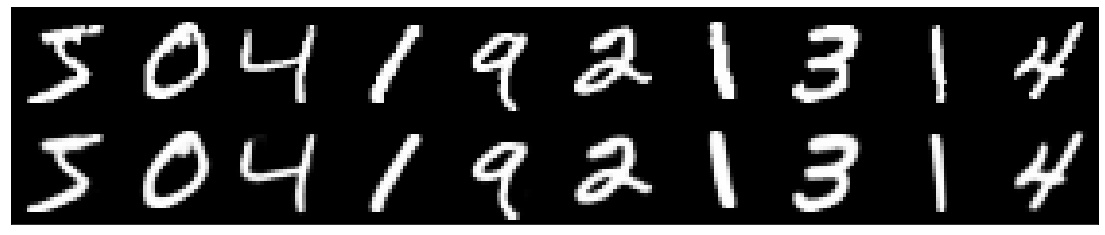

Epoch: [590/600], Batch: [239/240], Progress: 1.00%, Loss: 3404032701890560.0000, Minimum loss per epoch: 100000.0000
Epoch: [591/600], Batch: [239/240], Progress: 1.00%, Loss: 4505350363414528.0000, Minimum loss per epoch: 100000.0000
Epoch: [592/600], Batch: [239/240], Progress: 1.00%, Loss: 4116452349050880.0000, Minimum loss per epoch: 100000.0000
Epoch: [593/600], Batch: [239/240], Progress: 1.00%, Loss: 4806960683679744.0000, Minimum loss per epoch: 100000.0000
Epoch: [594/600], Batch: [239/240], Progress: 1.00%, Loss: 5340076720521216.0000, Minimum loss per epoch: 100000.0000
Epoch: [595/600], Batch: [239/240], Progress: 1.00%, Loss: 4692633486098432.0000, Minimum loss per epoch: 100000.0000
Epoch: [596/600], Batch: [239/240], Progress: 1.00%, Loss: 7066672900866048.0000, Minimum loss per epoch: 100000.0000
Epoch: [597/600], Batch: [239/240], Progress: 1.00%, Loss: 6321564257615872.0000, Minimum loss per epoch: 100000.0000
Epoch: [598/600], Batch: [239/240], Progress: 1.00%, Los

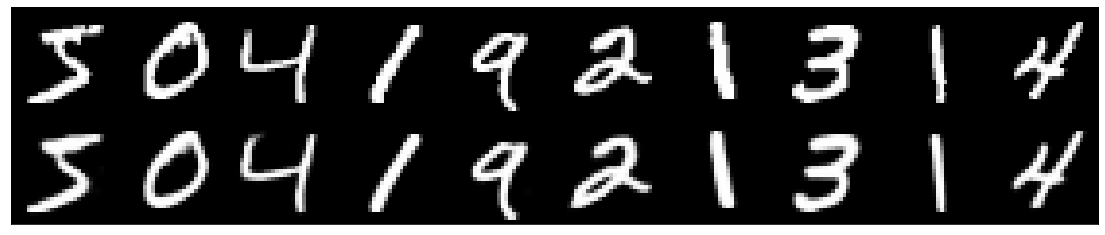

In [14]:
from sys import stdout


loss = []   # for loss graph
fig = plt.figure()
n_compare = 10
epochs_num_del_3 = epochs_num // 3

for epoch in range(epochs_num):
    ind = np.random.permutation(x_train.shape[0])
    
    if epoch > epochs_num_del_3:
        K.set_value(lambda_coeff, 1.1 * K.eval(lambda_coeff))
        
    n_batches = int(x_train.shape[0] / batchsize)
    min_loss_per_epoch = 100000
    for i in range(n_batches):
        next_batch = x_train[ind[i * batchsize: (i + 1) * batchsize], ...]
        
        theta_ = generateTheta(L, latent_dim)
        q_z_sample_ = generateQZ(batchsize, latent_dim)
        K.set_value(theta_var, theta_)
        K.set_value(q_z_sample_var, q_z_sample_)
        
        cur_loss = swae_autoencoder.train_on_batch(x=next_batch, y=None)
        if cur_loss < min_loss_per_epoch:
            min_loss_per_epoch = cur_loss
            
        loss.append(cur_loss)
        
        stdout.write("\rEpoch: [%d/%d], Batch: [%d/%d], Progress: %.2f%%, Loss: %.4f" %
                     (epoch, epochs_num, i, n_batches, i / n_batches, cur_loss))
        if i < n_batches - 1:
            stdout.flush()
        else:
            stdout.write(", Minimum loss per epoch: %.4f\n" % min_loss_per_epoch)
    
    if (epoch + 1) % 10 == 0:
        check_imgs = x_train[:n_compare]
        decoded_imgs = swae_autoencoder.predict(check_imgs)
        plot_digits(check_imgs, decoded_imgs)

### SAVE MODELS!!!

In [15]:
import os
import json

save_path = os.path.join("saved_models", "convolutional_swae")
if not os.path.exists(save_path):
    os.mkdir(save_path)

with open(os.path.join(save_path, "ae_%d_ldim_%d_epochs.json" % (latent_dim, epochs_num)), "w") as f:
    json.dump(swae_autoencoder.to_json(), f, indent=4)
swae_autoencoder.save_weights(os.path.join(save_path, "ae_%d_ldim_%d_epochs.h5") % (latent_dim, epochs_num))

with open(os.path.join(save_path, "ae_encoder_%d_ldim_%d_epochs.json" % (latent_dim, epochs_num)), "w") as f:
    json.dump(swae_encoder.to_json(), f, indent=4)
swae_encoder.save_weights(os.path.join(save_path, "ae_encoder_%d_ldim_%d_epochs.h5" % (latent_dim, epochs_num)))

with open(os.path.join(save_path, "ae_decoder_%d_ldim_%d_epochs.json" % (latent_dim, epochs_num)), "w") as f:
    json.dump(swae_decoder.to_json(), f, indent=4)
swae_decoder.save_weights(os.path.join(save_path, "ae_decoder_%d_ldim_%d_epochs.h5" % (latent_dim, epochs_num)))

### Generate random samples from q_z

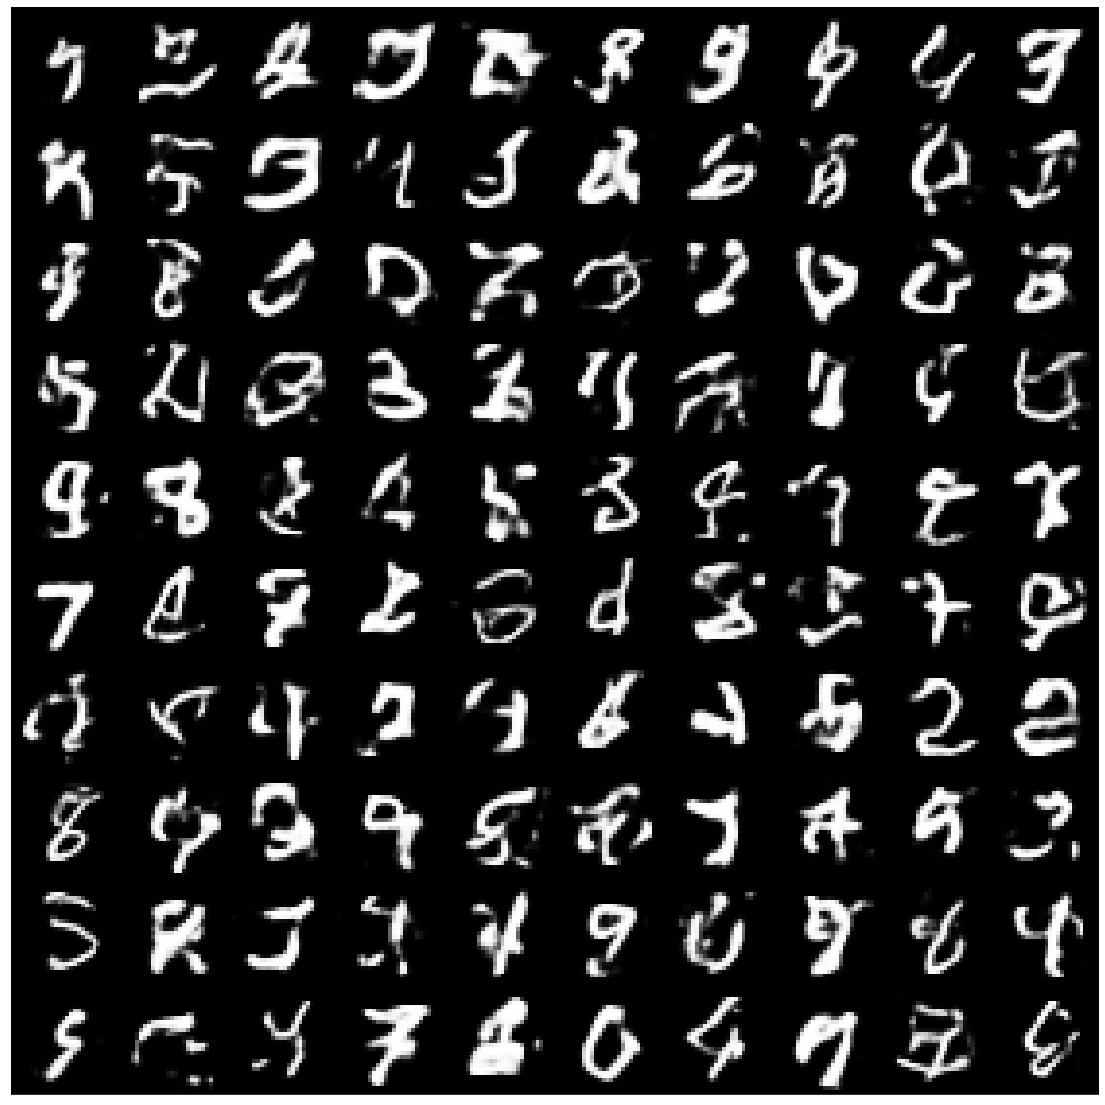

In [16]:
to_compare = []
for i in range(10):
    codes = generateQZ(n_compare, latent_dim)
    predicted = swae_decoder.predict(codes)
    to_compare.append(predicted[:n_compare])
plot_digits(*to_compare)

In [17]:
n_sample = 10
random_samples = generateQZ(n_sample ** 2, latent_dim)
random_decode_img = np.squeeze(swae_decoder.predict(random_samples))

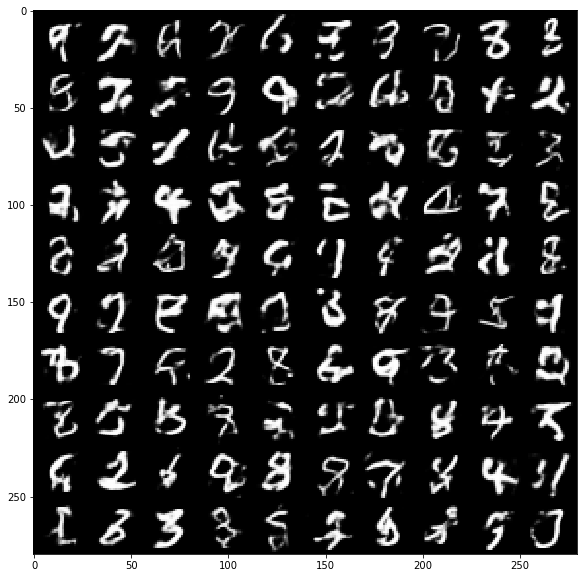

In [18]:
img_random = np.zeros((n_sample * 28, n_sample * 28))
count = 0
for i in range(n_sample):
    for j in range(n_sample):        
        img_random[i * 28: (i + 1) * 28, j * 28: (j + 1) * 28] = random_decode_img[count, ...]
        count += 1
        
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_random, cmap='gray')
plt.show()

### Loss function graphic

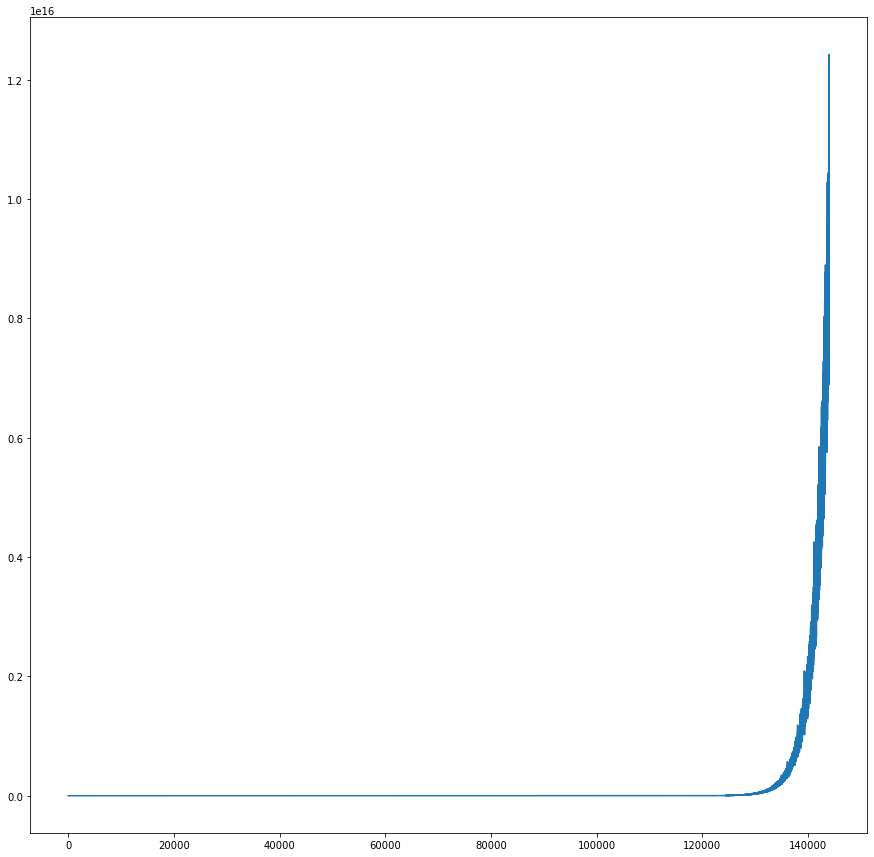

In [19]:
fig = plt.figure(figsize=(15, 15))
plt.plot(np.asarray(loss))